# preprocess the dataframe that stores wearable and cosmed data
## window data
## prepare them for training and testing later

In [1]:
import numpy as np
import argparse
from numpy import linalg as LA

import os
import math
import json

import collections

import pandas as pd
from sklearn.linear_model import LinearRegression

from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures


import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
matplotlib.rc( 'savefig', facecolor = 'white' )
from matplotlib import pyplot
%matplotlib inline

i_seed = 0

import sys
sys.path.append('../') # add this line so Data and data are visible in this file
sys.path.append('../../') # add this line so Data and data are visible in this file
sys.path.append('../PatchWand/') # add this line so Data and data are visible in this file

# from PatchWand import *
from filters import *
from setting import *
from segmentation import *
# from stage1_patch import *
# from TimeStampReader import *
# from Subject import *
# from PatchParser import *
from preprocessing import *
from ECG_module import *
from PPG_module import *
from evaluate import *
from stage1_cosmed import *
from stage3_preprocess import *
from dataIO import *
from resp_module import *

from importlib import reload
%load_ext autoreload
%autoreload 2

In [2]:
# plot_surrogate_resp

In [3]:
parser = argparse.ArgumentParser(description='SpO2_estimate')
parser.add_argument('--input_folder', metavar='input_folder', help='input_folder',
                    default='../')
parser.add_argument('--output_folder', metavar='output_folder', help='output_folder',
                    default='../')
parser.add_argument('--reject_ids', metavar='reject_ids', help='reject_ids',
                    default=['sub112'])
parser.add_argument('--training_params_file', metavar='training_params_file', help='training_params_file',
                    default='training_params_list.json')


# checklist 3: comment first line, uncomment second line
args = parser.parse_args(['--input_folder', '../../data/stage2/', 
                          '--output_folder', '../../data/stage3/',
#                           '--reject_ids',  ['sub102', 'sub105','sub108','sub109','sub112','sub114','sub212'],
#                           '--reject_ids',  ['sub109','sub112'],
                          # '--reject_ids',  ['sub112'],
                          '--training_params_file', 'training_params_resp.json',
                         ])
# args = parser.parse_args(['--input_folder', '../../data/stage2/', 
#                           '--output_folder', '../../data/stage3_FL/',
#                           '--reject_ids',  ['sub109','sub112'],
#                           '--training_params_file', 'training_params_HR.json',
#                          ])
# args = parser.parse_args()
print(args)

Namespace(input_folder='../../data/stage2/', output_folder='../../data/stage3/', reject_ids=['sub112'], training_params_file='training_params_resp.json')


# set up using args

In [4]:
reject_ids = args.reject_ids

inputdir = args.input_folder
outputdir = args.output_folder

if not os.path.exists(outputdir):
    os.makedirs(outputdir)
    
training_params_file = args.training_params_file

with open(training_params_file) as json_file:
    training_params_list = json.load(json_file)
    
training_params = training_params_list[0]

# create folders
## `/resp`: inspect respiratory signals
## `/cardiac`: inspect cardiac signals
## `/winXX_overlapXX`: store windowed filtered signals

In [5]:
if training_params['extract_resp']:
    outputdir_resp = outputdir + 'resp/'

    if not os.path.exists(outputdir_resp):
        os.makedirs(outputdir_resp)
    print('will export data to', outputdir_resp)

will export data to ../../data/stage3/resp/


In [6]:
# if training_params['extract_resp']:
outputdir_cardiac = outputdir + 'cardiac/'

if not os.path.exists(outputdir_cardiac):
    os.makedirs(outputdir_cardiac)
print('will export data to', outputdir_cardiac)

will export data to ../../data/stage3/cardiac/


In [7]:
outputdir = outputdir + 'win{}_overlap{}/'.format(str(training_params['window_size']), \
                                                        int(training_params['overlap']*100),)

if not os.path.exists(outputdir):
    os.makedirs(outputdir)
print('will export data to', outputdir)




will export data to ../../data/stage3/win60_overlap90/


In [8]:
outputdir_diagnostic = outputdir + 'diagnostic/'

if not os.path.exists(outputdir_diagnostic):
    os.makedirs(outputdir_diagnostic)

In [9]:
list_signal = training_params['list_signal']
list_feature = training_params['list_feature']
list_output = training_params['list_output']
list_meta = training_params['list_meta']
FS_RESAMPLE_DL = training_params['FS_RESAMPLE_DL']
window_size = training_params['window_size'] # s
overlap = training_params['overlap'] # out of 1

task_names =  training_params['task_names'] 
# v1: ["Baseline 0", "Recovery 0", "Recovery 1", "Recovery 2", "6MWT 0", "Recovery 3", "Recovery 4"],
# v2: ["Baseline 0", "Recovery 0", "Recovery 1", "Recovery 2", "Recovery 3", "Recovery 4", "6MWT 0", "Stair 0", "Run 0"],
# v3: ["Baseline 0", "Recovery 0", "Recovery 1", "Recovery 2", "Recovery 3", "Recovery 4", "6MWT 0", "6MWT-R 0", "Stair 0", "Walk 0", "Run 0"],

Fs = FS_RESAMPLE
downsample_factor = int(Fs / FS_RESAMPLE_resp)
print('downsample_factor is:', downsample_factor)
print('Fs will be resmaple to {} Hz'.format(FS_RESAMPLE_resp) )

downsample_factor is: 50
Fs will be resmaple to 5 Hz


In [10]:
if 'signal_normalization' not in training_params:
    training_params['signal_normalization'] = 'none' # default
    # training_params['signal_normalization'] = 'zeromean_unitvar'

# get demographic data

In [11]:
filename_subinfo = '../../data/raw/FS Subject Information.xlsx'
df_subinfo = pd.read_excel(filename_subinfo, sheet_name='Subject info') 

i_sub_last = np.where(df_subinfo['Subject_ID'].isnull()==True)[0][0]
df_subinfo = df_subinfo[:i_sub_last]

df_subinfo = df_subinfo[['Subject_ID', 'Age', 'Height(cm)', 'Weight(Kg)', 'Gender(0=Male,1=Female)', 'Fitzpatrick', '6MWT distance (m)', '6MWT-R distance (m)']]
df_subinfo = df_subinfo.rename(columns={'Height(cm)': 'Height', 'Weight(Kg)': 'Weight', 'Gender(0=Male,1=Female)': 'Gender'})


from sklearn.preprocessing import OrdinalEncoder

def prepare_OrdinalEncoding(data):
    enc = OrdinalEncoder()
    enc.fit(data[:,None])
    enc.categories_
    return enc.transform(data[:,None])[:,0]

df_subinfo.shape

(22, 8)

# Processing the demographic data and add a few more columns (Gender_encoded and BMR)

# compute BMR (kcal/day) -> (kcal/min)
### The Harris-Benedict Equation is often used to estimate basal metabolic rate.

### Men: BMR = 88.362 + (13.397 x weight in kg) + (4.799 x height in cm) - (5.677 x age in years)
### Women: BMR = 447.593 + (9.247 x weight in kg) + (3.098 x height in cm) - (4.330 x age in years)

In [12]:
# initialization
df_subinfo['BMR'] = 0

# comptue basal metabolic rate (BMR) for male
male_mask = df_subinfo['Gender']==1
df_male = df_subinfo[male_mask]
df_subinfo.loc[male_mask, ['BMR']] = 88.362 + (3.397 * df_male['Weight']) + (4.799 * df_male['Height']) - (5.677 *  df_male['Age'])

# comptue basal metabolic rate for female
female_mask = df_subinfo['Gender']==2
df_female = df_subinfo[female_mask]
df_subinfo.loc[female_mask, ['BMR']] = 447.593 + (9.247 * df_female['Weight']) + (3.098 * df_female['Height']) - (4.330 *  df_female['Age'])

# convert BMR from kcal/day to kcal/min
df_subinfo['BMR'] = df_subinfo['BMR']/24/60

In [13]:
# compute gender encoded so it starts from 0
df_subinfo['Gender_encoded'] = prepare_OrdinalEncoding(df_subinfo['Gender'].values) # 0=male, 1=female
df_subinfo

Subject_ID   Age  Height  Weight Gender  Fitzpatrick  6MWT distance (m)  \
0         101  26.0  172.00   90.00      1          2.0            286.500   
1         102  30.0  177.80   75.00      1          2.0            280.720   
2         103  29.0  174.00   70.00      1          2.0            302.100   
3         104  21.0  185.40   79.30      1          1.0            302.460   
4         105  21.0  177.80   68.00      1          1.0            311.200   
5         106  28.0  178.00   76.00      1          1.0            408.000   
6         107  27.0  194.00   90.72      1          1.0            296.150   
7         108  24.0  180.34   70.76      1          2.0            240.240   
8         109  21.0  160.02   52.16      2          2.0            578.900   
9         110  22.0  182.88   93.00      1          3.0            578.760   
10        111  28.0  153.00   45.00      2          1.0            611.520   
11        112  24.0  180.34   61.24      1          2.0            574.840   
12        113  24.0  198.12  104.33      1          1.0            565.820   
13        114  27.0  175.00   60.00      1          1.0            605.200   
14        115  22.0  175.26   54.43      1          4.0            666.885   
15        116  26.0  160.00   56.70      2          1.0            524.160   
16        117  24.0  155.00   38.50      2          3.0            578.760   
17        118  23.0  172.72   69.40      2          2.0            589.680   
18        119  20.0  170.18   68.04      2          2.0            580.350   
19        120  25.0  161.00   52.00      2          2.0            543.280   
20        121  24.0  157.48   55.34      2          1.0            614.470   
21        212  24.0  180.34   57.60      1          2.0            596.180   

    6MWT-R distance (m)       BMR  Gender_encoded  
0               264.550  0.744388             0.0  
1               272.090  0.712562             0.0  
2               289.380  0.692045             0.0  
3               290.840  0.783515             0.0  
4               303.960  0.731530             0.0  
5               379.080  0.723472             0.0  
6               288.680  0.815462             0.0  
7               209.770  0.734679             0.0  
8               537.029  0.926895             1.0  
9               574.140  0.803493             0.0  
10              573.940  0.844765             1.0  
11              569.120  0.712221             0.0  
12              459.240  0.873126             0.0  
13              589.650  0.679672             0.0  
14              546.770  0.687111             0.0  
15              458.640  0.940971             1.0  
16              464.220  0.819356             1.0  
17              505.820  1.058911             1.0  
18              494.300  1.053734             1.0  
19              546.000  0.915948             1.0  
20              546.000  0.932830             1.0  
21              530.060  0.703634             0.0

In [14]:
print('Age: {:.2f}±{:.2f} yrs'.format(df_subinfo['Age'].mean(), df_subinfo['Age'].std()))
print('Weight: {:.2f}±{:.2f} kg'.format(df_subinfo['Weight'].mean(), df_subinfo['Weight'].std()))
print('Height: {:.2f}±{:.2f} cm'.format(df_subinfo['Height'].mean(), df_subinfo['Height'].std()))
print('Gender: {} males {} females'.format((df_subinfo['Gender']==1).sum(), (df_subinfo['Gender']==2).sum()))

Age: 24.55±2.81 yrs
Weight: 67.61±16.61 kg
Height: 173.67±11.98 cm
Gender: 14 males 8 females


In [15]:
# task_names = ['Baseline 0', 'Recovery 0', 'Recovery 1', 'Recovery 2', 'Recovery 3']
# task_names = ['Baseline 0', 'Recovery 2']


In [16]:
# stationary_names = ['Baseline 0']
# # stationary_names = ['Baseline 0']
# for j in range(5):
#     stationary_names.append('Recovery ' + str(j))
# # stationary_names.append( '6MWT 0' )
# # stationary_names.append( '6MWT-R 0' )
# # stationary_names.append( 'Stair 0' )
# # stationary_names.append( 'Walk 0' )
# # stationary_names.append( 'Run 0' )

# stationary_names

In [17]:
# stationary_names = ['Baseline 0', 'Standing 0', 'Run 0']
# # stationary_names = ['Baseline 0']
# for j in range(5):
#     stationary_names.append('Recovery ' + str(j))
# # stationary_names.append( '6MWT 0' )
# # stationary_names.append( '6MWT-R 0' )
# # stationary_names.append( 'Stair 0' )
# # stationary_names.append( 'Walk 0' )
# # stationary_names.append( 'Run 0' )

# stationary_names

# get sync data

## change activity name
## maybe remove scaling

## 102 talked too much during recovery
## 105 ECG
## 108 ECG
## 109 ECG
## 112 cosmed
## 114 bad baseline (mask problem)
## 212 bad baseline (mask problem)

In [18]:
# reject_ids = ['sub102', 'sub105','sub108','sub109','sub112','sub114','sub212']

In [19]:
task_names

['Baseline 0',
 'Recovery 0',
 'Recovery 1',
 'Recovery 2',
 'Recovery 3',
 'Recovery 4',
 '6MWT 0',
 '6MWT-R 0',
 'StairDown0',
 'StairUp0',
 'StairDown1',
 'Walk 0',
 'Run 0']

# get only the important tasks

In [20]:
task_names

['Baseline 0',
 'Recovery 0',
 'Recovery 1',
 'Recovery 2',
 'Recovery 3',
 'Recovery 4',
 '6MWT 0',
 '6MWT-R 0',
 'StairDown0',
 'StairUp0',
 'StairDown1',
 'Walk 0',
 'Run 0']

# get the data, split them based on task names

In [21]:
task_names

['Baseline 0',
 'Recovery 0',
 'Recovery 1',
 'Recovery 2',
 'Recovery 3',
 'Recovery 4',
 '6MWT 0',
 '6MWT-R 0',
 'StairDown0',
 'StairUp0',
 'StairDown1',
 'Walk 0',
 'Run 0']

In [22]:
# t_dur_dict

In [23]:
no_scaling = False

df_sync = pd.DataFrame()
t_dur_dict = collections.defaultdict(dict)

for i in range(300):
    subject_id = 'sub'+str(i)
    
#     if int(subject_id.split('sub')[1]) >116:
#         continue

    # these subjects don't have good chest patch
    # TODO: "transplant" the ECG of their other patches to the chest
#     if subject_id =='sub105' or subject_id =='sub108' or subject_id =='sub109' or subject_id =='sub112' or subject_id =='sub117':
#         continue
    
    # TODO: "transplant" the ECG of their other patches to the chest
#     if subject_id =='sub212' or subject_id =='sub114':
#         continue

    inputdir_sub = inputdir+subject_id+'/'
    if subject_id not in os.listdir(inputdir):
        continue
        
    if subject_id in reject_ids:
        continue
   
    print('subject_id is ', subject_id)

    # read the whole dataframe of a subject
    for syn_file in os.listdir(inputdir_sub):
        if '.feather'  in syn_file:
            df_sub = pd.read_feather(inputdir_sub+syn_file)
            

    # get raw task names except for Transition
    task_unique = df_sub['task'].unique()
    task_unique = task_unique[task_unique!='Transition']

    # iterate through all tasks
    for task_name in task_names:
        
        # target the task first
        df_task = df_sub[df_sub['task']==task_name].copy()
        df_task = df_task.reset_index(drop=True)
        # get subject_id
        df_task['subject_id'] = subject_id.split('sub')[1]
        
#         if subject_id!='sub101':
#             continue
#         if task_name!='6MWT 0':
#             continue

        # rename the task name
        if 'Recovery' not in task_name:
            task_name_new = task_name.split(' ')[0]
        else:
            # get recovery index
            i_recovery = np.where(task_unique==task_name)[0]

            # the index of the task associated with this recovery is i_recovery-1. Get its name
            exercise_name = task_unique[i_recovery-1][0]

            # spell out new recovery name
            task_name_new = ' '.join([task_name.split(' ')[0], exercise_name.split(' ')[0]])
        
        # compute the duration of a task
        t_dur = df_task['time'].max()-df_task['time'].min()
#         print('old name: {}\tnew  name: {}\tt_dur: {:.2f}'.format(task_name, task_name_new, t_dur).expandtabs(35) )
        df_task['task'] = task_name_new
        
        # store the task duration (in sec)
        t_dur_dict[subject_id][task_name_new] = t_dur

        df_sync = df_sync.append(df_task)
    
df_sync = df_sync.reset_index(drop=True)

subject_id is  sub101
subject_id is  sub102
subject_id is  sub103
subject_id is  sub104
subject_id is  sub105
subject_id is  sub106
subject_id is  sub107
subject_id is  sub108
subject_id is  sub109
subject_id is  sub110
subject_id is  sub111
subject_id is  sub113
subject_id is  sub114
subject_id is  sub115
subject_id is  sub116
subject_id is  sub117
subject_id is  sub118
subject_id is  sub119
subject_id is  sub120
subject_id is  sub121
subject_id is  sub212


In [24]:
print( 'unique tasks:', df_sync['task'].unique() )
print( 'unique subject IDs:', df_sync['subject_id'].unique() )

unique tasks: ['Baseline' 'Recovery 6MWT' 'Recovery 6MWT-R' 'Recovery StairDown1'
 'Recovery Walk' 'Recovery Run' '6MWT' '6MWT-R' 'StairDown0' 'StairUp0'
 'StairDown1' 'Walk' 'Run']
unique subject IDs: ['101' '102' '103' '104' '105' '106' '107' '108' '109' '110' '111' '113'
 '114' '115' '116' '117' '118' '119' '120' '121' '212']


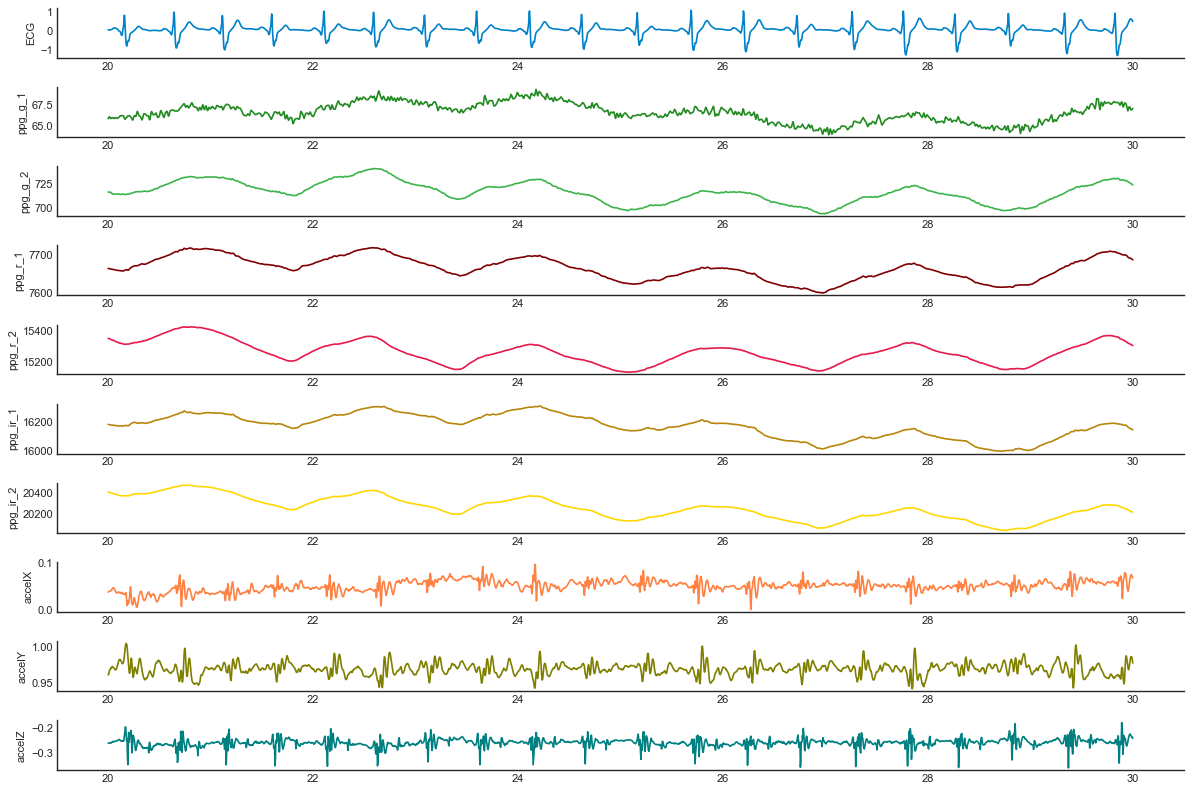

In [72]:
mask = (df_sync['subject_id']=='115') & (df_sync['task']=='Recovery 6MWT')
df = df_sync[mask].copy()

t_arr = df['time'].values
t_arr = t_arr-t_arr.min()

xmin, xmax = 20, 30

mask_seg = (t_arr>=xmin) & (t_arr<=xmax)

inspect_sig_names = ['ECG', 'ppg_g_1', 'ppg_g_2', 'ppg_r_1', 'ppg_r_2', 'ppg_ir_1', 'ppg_ir_2', 'accelX', 'accelY', 'accelZ']
fig, axes = plt.subplots(len(inspect_sig_names),1, figsize=(15,len(inspect_sig_names)), dpi=80)

for ax, sig_name in zip(axes, inspect_sig_names):
    ax.plot(t_arr[mask_seg], df[sig_name].values[mask_seg], color_dict[sync_color_dict[sig_name]])
    ax.set_ylabel(sig_name)

for ax in axes:
    # ax.set_xlim(xmin, xmax)
    ax_no_top_right(ax)
    
fig.tight_layout()

In [78]:
color_dict

{'Red': '#e6194b',
 'Green': '#3cb44b',
 'Yellow': '#ffe119',
 'Blue': '#0082c8',
 'Orange': '#f58231',
 'Purple': '#911eb4',
 'Cyan': '#46f0f0',
 'Magenta': '#e6194b',
 'Navy': '#000080',
 'Teal': '#008080',
 'Brown': '#aa6e28',
 'Maroon': '#800000',
 'ForestGreen': '#228b22',
 'SteelBlue': '#4682B4',
 'MidnightBlue': '#1A4876',
 'RoyalPurple': '#7851A9',
 'MangoTando': '#FF8243',
 'Sunglow': '#FFCF48',
 'Lavender': '#e6beff',
 'Lime': '#d2f53c',
 'Pink': '#fabebe',
 'Olive': '#808000',
 'Coral': '#ffd8b1',
 'Cardinal': '#CC2336',
 'Black': '#000000',
 'Deep Carrot Orange': '#E4682A',
 'burntumber': '#8A3324',
 'darkgoldenrod': '#b8860b',
 'gold': '#FFD700',
 'Firebrick': '#b22222',
 'White': '#FFFFFF'}

(0.100080064051241, 19.915932746196958)

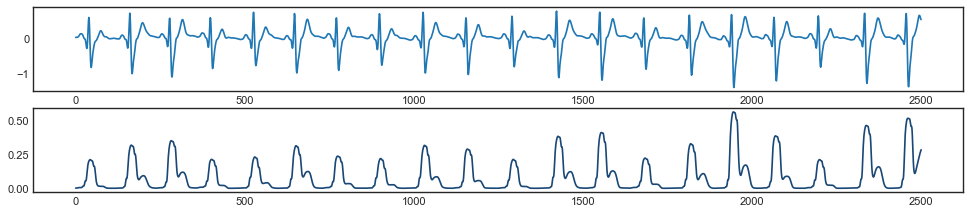

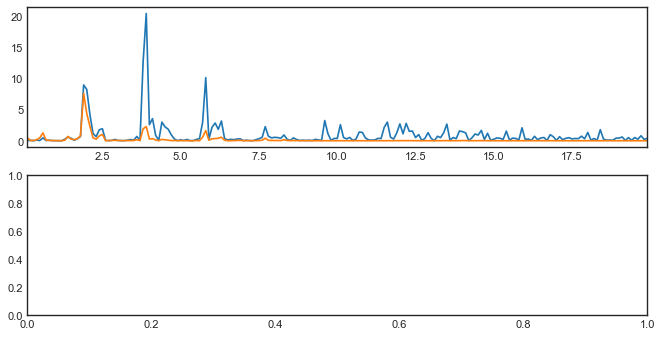

In [83]:
sig_name = 'ECG'
sig = df[sig_name].values[mask_seg]
sig = get_padded_filt(sig, filter_padded=1, lowcutoff=0.2, highcutoff=30, Fs=FS_RESAMPLE)

# sig_smooth = get_padded_filt((sig**2, filter_padded=1, lowcutoff=0.1, highcutoff=4, Fs=FS_RESAMPLE)
# sig_smooth = get_smooth(sig**2, N=80)


sig_smooth = get_smooth(sig**2, N=25)

fig, axes = plt.subplots(2,1, figsize=(15,3), dpi=80)
axes[0].plot(sig)
axes[1].plot(sig_smooth, color=color_dict['MidnightBlue'])


fig, axes = plt.subplots(2,1, figsize=(10,5), dpi=80)


xf, yf = get_psd(sig, Fs=FS_RESAMPLE)
mask = (xf>=0.1) & (xf<=20)
axes[0].plot(xf[mask], yf[mask])
axes[0].set_xlim(xf[mask].min(),xf[mask].max())

xf, yf = get_psd(sig_smooth, Fs=FS_RESAMPLE)
mask = (xf>=0.1) & (xf<=20)
axes[0].plot(xf[mask], yf[mask])
axes[0].set_xlim(xf[mask].min(),xf[mask].max())

In [26]:
# # sig_name = 'ppg_ir_2'
# sig_name = 'accelY'
# aaa = df[sig_name].values[mask_seg]
# bbb = get_padded_filt(aaa, lowcutoff=1, highcutoff=10, Fs=FS_RESAMPLE)


In [27]:
# plt.figure(figsize=(20,2))
# plt.plot(aaa)


In [28]:
# plt.figure(figsize=(20,2))
# plt.plot(bbb)

In [29]:
# xf_ppg, yf_ppg


In [30]:
# xf_ppg, yf_ppg = get_psd(bbb, FS_RESAMPLE)
# mask = (xf_ppg>=0.05) & (xf_ppg<=10)
# plt.plot(xf_ppg[mask], yf_ppg[mask])

In [31]:
# xf, yf = get_psd(bbb, FS_RESAMPLE)
# mask = (xf>=0.05) & (xf<=10)
# plt.plot(xf[mask], yf[mask])

# plt.plot(xf_ppg[mask], yf_ppg[mask]/10000)
# plt.ylim(-1,1000)

In [32]:
# df['RR_cosmed'][mask_seg].values/60

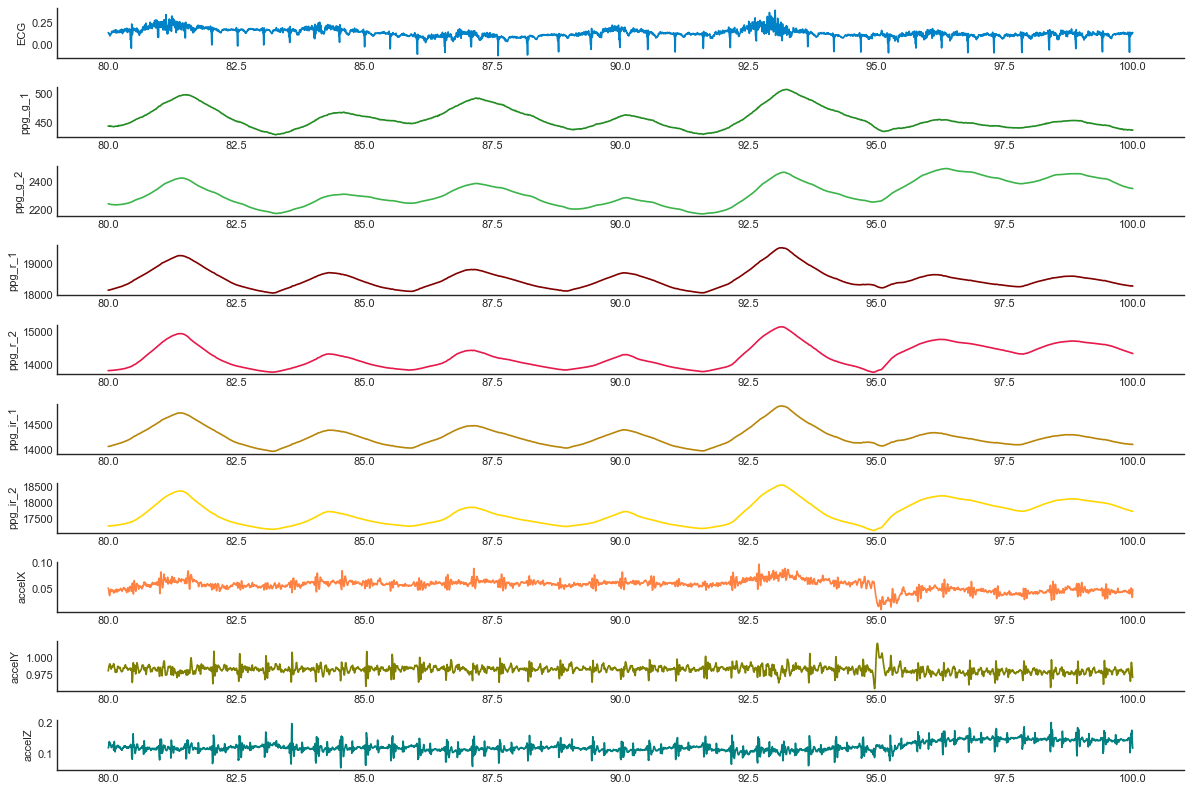

In [33]:
mask = (df_sync['subject_id']=='117') & (df_sync['task']=='Recovery Walk')
df = df_sync[mask].copy()

t_arr = df['time'].values
t_arr = t_arr-t_arr.min()

xmin, xmax = 80, 100

mask_seg = (t_arr>=xmin) & (t_arr<=xmax)

inspect_sig_names = ['ECG', 'ppg_g_1', 'ppg_g_2', 'ppg_r_1', 'ppg_r_2', 'ppg_ir_1', 'ppg_ir_2', 'accelX', 'accelY', 'accelZ']
fig, axes = plt.subplots(len(inspect_sig_names),1, figsize=(15,len(inspect_sig_names)), dpi=80)

for ax, sig_name in zip(axes, inspect_sig_names):
    ax.plot(t_arr[mask_seg], df[sig_name].values[mask_seg], color_dict[sync_color_dict[sig_name]])
    ax.set_ylabel(sig_name)

for ax in axes:
    # ax.set_xlim(xmin, xmax)
    ax_no_top_right(ax)
    
fig.tight_layout()

In [34]:
accelZ = df['accelZ'].values
accelY = df['accelY'].values
accelX = df['accelX'].values
ECG = df['ECG'].values
time = df['time'].values
time = time-time.min()

	 use S peaks
	 use S peaks


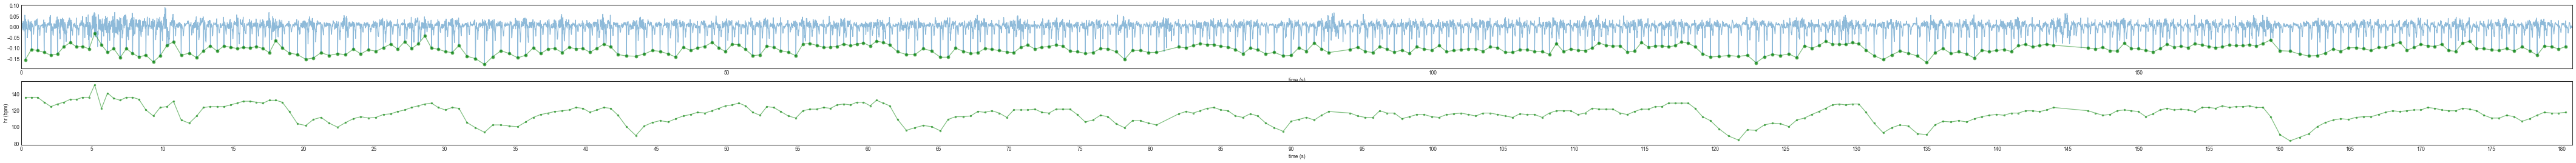

In [35]:
# QRS_detector_dict_diagnostics

QRS_detector_dict = task_HR_detector(ECG, FS_RESAMPLE, beat_choice='i_S_peaks')

i_S_peaks = QRS_detector_dict['i_S_peaks']

In [36]:
scgZ = get_padded_filt(accelX, lowcutoff=FILT_SCG[0], highcutoff=FILT_SCG[1], Fs=FS_RESAMPLE)

scgZ_s1 = np.zeros(scgZ.shape)

In [37]:
N_s1 = int(0.1 * FS_RESAMPLE)

for i_peak in i_S_peaks:
    i_start, i_end = i_peak-N_s1//2, i_peak+N_s1
    scgZ_s1[i_start:i_end] = scgZ[i_start:i_end]

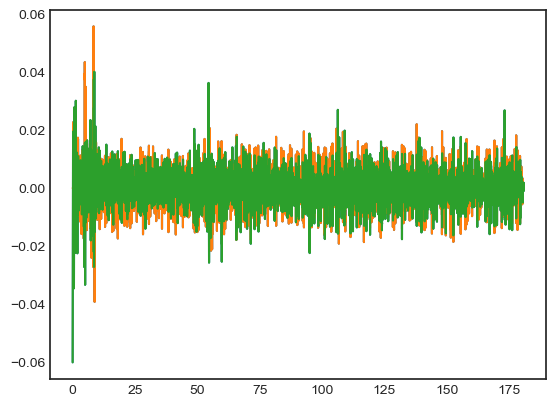

In [38]:
plt.plot(time, scgZ)
plt.plot(time, scgZ_s1)

plt.plot(time, scgZ-scgZ_s1)

(0, 100)

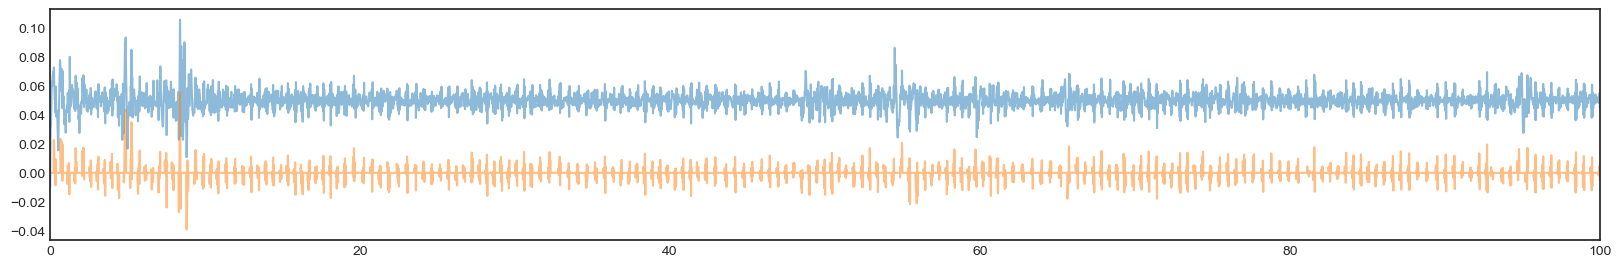

In [39]:
plt.figure(figsize=(20,3))

plt.plot(time, scgZ+0.05, alpha=0.5)
plt.plot(time, scgZ_s1, alpha=0.5)
# plt.plot(time, scgZ_s1-scgZ, alpha=0.5)
plt.xlim(0,100)

(10, 40)

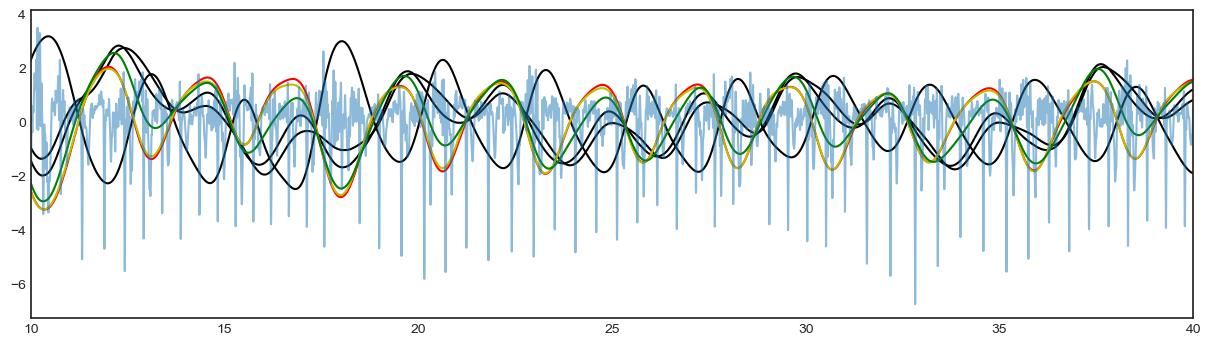

In [40]:
ppg_r_2 = df['ppg_r_2'].values
ppg_ir_2 = df['ppg_ir_2'].values
ppg_g_2 = df['ppg_g_2'].values
ECG = df['ECG'].values
time = df['time'].values
time = time-time.min()

# ppg_r_2 = get_padded_filt(ppg_r_2, lowcutoff=FILT_RESP[0], highcutoff=FILT_RESP[1], Fs=FS_RESAMPLE)/ppg_r_2
# ppg_ir_2 = get_padded_filt(ppg_ir_2, lowcutoff=FILT_RESP[0], highcutoff=FILT_RESP[1], Fs=FS_RESAMPLE)/ppg_ir_2

ppg_r_2 = -get_padded_filt(ppg_r_2, lowcutoff=FILT_RESP[0], highcutoff=FILT_RESP[1], Fs=FS_RESAMPLE)/ppg_r_2
ppg_ir_2 = -get_padded_filt(ppg_ir_2, lowcutoff=FILT_RESP[0], highcutoff=FILT_RESP[1], Fs=FS_RESAMPLE)/ppg_ir_2
ppg_g_2 = -get_padded_filt(ppg_g_2, lowcutoff=FILT_RESP[0], highcutoff=FILT_RESP[1], Fs=FS_RESAMPLE)/ppg_g_2

ppg_diff = ppg_ir_2 - ppg_r_2
ppg_diff2 = ppg_g_2 - ppg_ir_2
ppg_diff3 = ppg_g_2 - ppg_r_2

ECG = get_padded_filt(ECG, lowcutoff=FILT_ECG[0], highcutoff=FILT_ECG[1], Fs=FS_RESAMPLE)


plt.figure(figsize=(15,4))
plt.plot(time, ppg_diff / ppg_diff.std(), color='black')
plt.plot(time, ppg_diff2 / ppg_diff2.std(), color='black')
plt.plot(time, ppg_diff3 / ppg_diff3.std(), color='black')
plt.plot(time, ppg_r_2 / ppg_r_2.std(), color='r')
plt.plot(time, ppg_ir_2 / ppg_ir_2.std(), color='y')
plt.plot(time, ppg_g_2 / ppg_g_2.std(), color='g')
plt.plot(time, ECG / ECG.std(), alpha=0.5)
# plt.plot(time, ppg_r_2)
# plt.plot(time, ppg_ir_2)
plt.xlim(10,40)
# plt.ylim(-0.005,0.005)
# plt.plot(ppg_ir_2)

In [41]:
# plt.plot(df['RR_cosmed'])

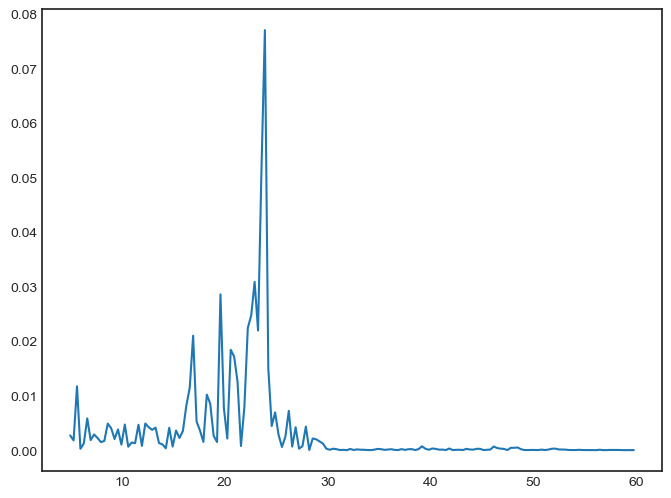

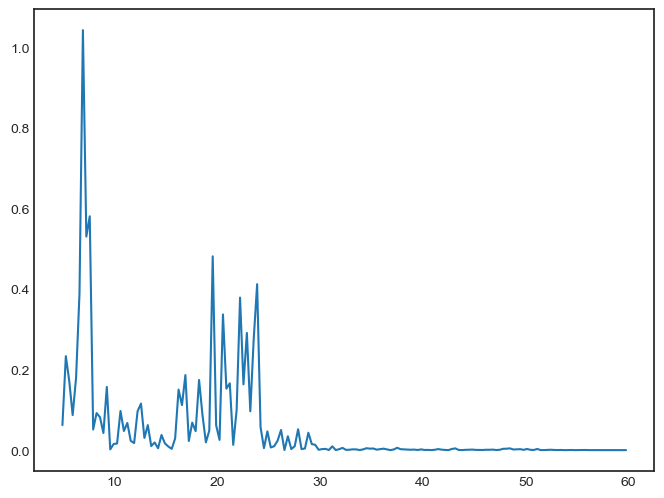

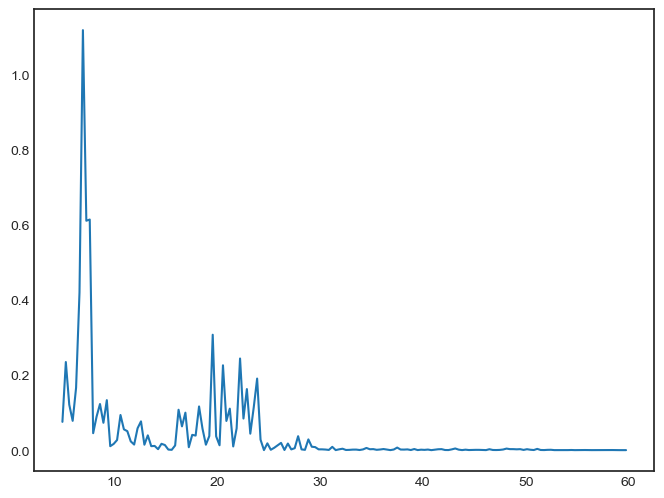

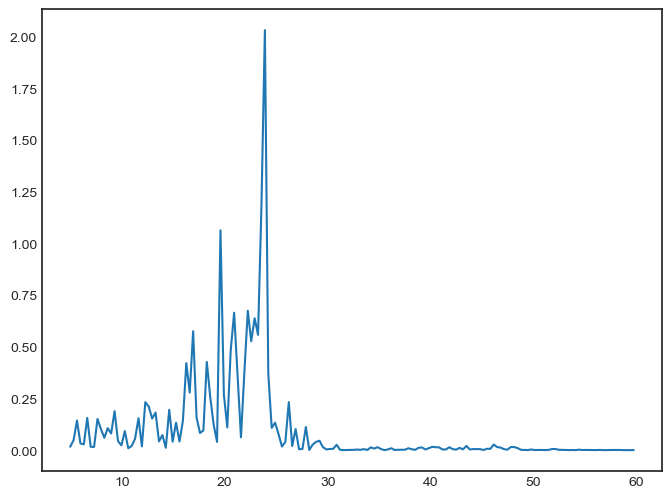

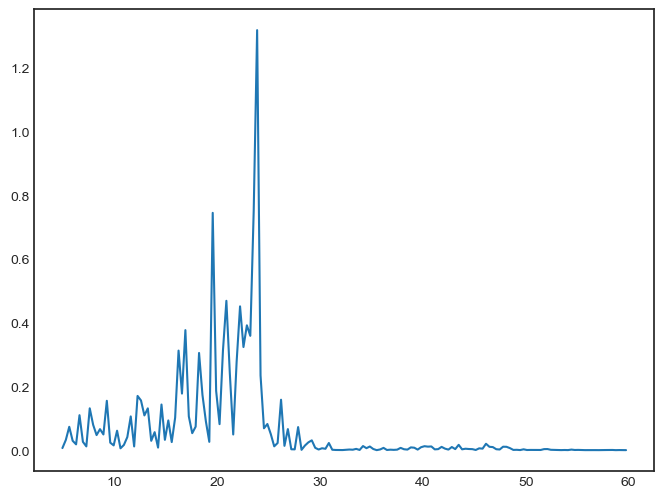

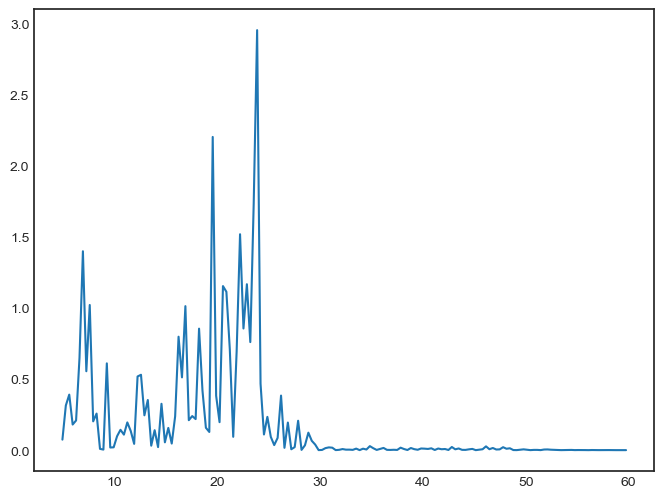

In [42]:

for sig in [ppg_diff,ppg_diff2,ppg_diff3, ppg_r_2, ppg_ir_2, ppg_g_2]:
    xf, yf = get_psd(sig, FS_RESAMPLE)
    mask = (xf>=FILT_RESP[0]) & (xf<=FILT_RESP[1])
    xf = xf * 60
    xf, yf = xf[mask], yf[mask]

    plt.figure(figsize=(8,6))
    plt.plot(xf, yf)

In [43]:
ppg_r_2 = df['ppg_r_2'].values
ppg_ir_2 = df['ppg_ir_2'].values
ppg_g_2 = df['ppg_g_2'].values
ECG = df['ECG'].values
time = df['time'].values
time = time-time.min()

# ppg_r_2 = df['ppg_r_2'].values
# ppg_ir_2 = df['ppg_ir_2'].values
# ppg_g_2 = df['ppg_g_2'].values


lowcutoff,  highcutoff = FILT_RESP


ppg_r_2 = ppg_r_2 / get_smooth(ppg_r_2, N=FS_RESAMPLE*2)
ppg_ir_2 = ppg_ir_2 / get_smooth(ppg_ir_2, N=FS_RESAMPLE*2)
ppg_g_2 = ppg_g_2 / get_smooth(ppg_g_2, N=FS_RESAMPLE*2)

X = 3 * ppg_r_2 - 2 * ppg_g_2
Y = 1.5 * ppg_r_2 + ppg_g_2 - 1.5 * ppg_ir_2

X = get_padded_filt(X, lowcutoff=lowcutoff, highcutoff=highcutoff, Fs=FS_RESAMPLE)
Y = get_padded_filt(Y, lowcutoff=lowcutoff, highcutoff=highcutoff, Fs=FS_RESAMPLE)

alpha = np.std(X) / np.std(Y)

S = 3*(1-alpha/2) * ppg_r_2 - 2*(1+alpha/2) * ppg_g_2 + 3*(alpha/2) * ppg_ir_2



ppg_r_2 = -get_padded_filt(ppg_r_2, lowcutoff=lowcutoff, highcutoff=highcutoff, Fs=FS_RESAMPLE)/ppg_r_2
ppg_ir_2 = -get_padded_filt(ppg_ir_2, lowcutoff=lowcutoff, highcutoff=highcutoff, Fs=FS_RESAMPLE)/ppg_ir_2
ppg_g_2 = -get_padded_filt(ppg_g_2, lowcutoff=lowcutoff, highcutoff=highcutoff, Fs=FS_RESAMPLE)/ppg_g_2
S = -get_padded_filt(S, lowcutoff=lowcutoff, highcutoff=highcutoff, Fs=FS_RESAMPLE)/S

ECG = get_padded_filt(ECG, lowcutoff=FILT_ECG[0], highcutoff=FILT_ECG[1], Fs=FS_RESAMPLE)


In [44]:
# ppg_r_2 = df['ppg_r_2'].values[:5000]
# plt.plot(ppg_r_2)

# plt.plot(get_smooth(ppg_r_2, N=FS_RESAMPLE*2))

In [45]:
# ppg_r_2 = get_padded_filt(ppg_r_2, lowcutoff=FILT_PPG[0], highcutoff=FILT_PPG[1], Fs=FS_RESAMPLE)
# plt.plot(ppg_r_2)

In [46]:
# X = 3 * ppg_r_2 - 2 * ppg_g_2
# Y = 1.5 * ppg_r_2 + ppg_g_2 - 1.5 * ppg_ir_2

(20, 100)

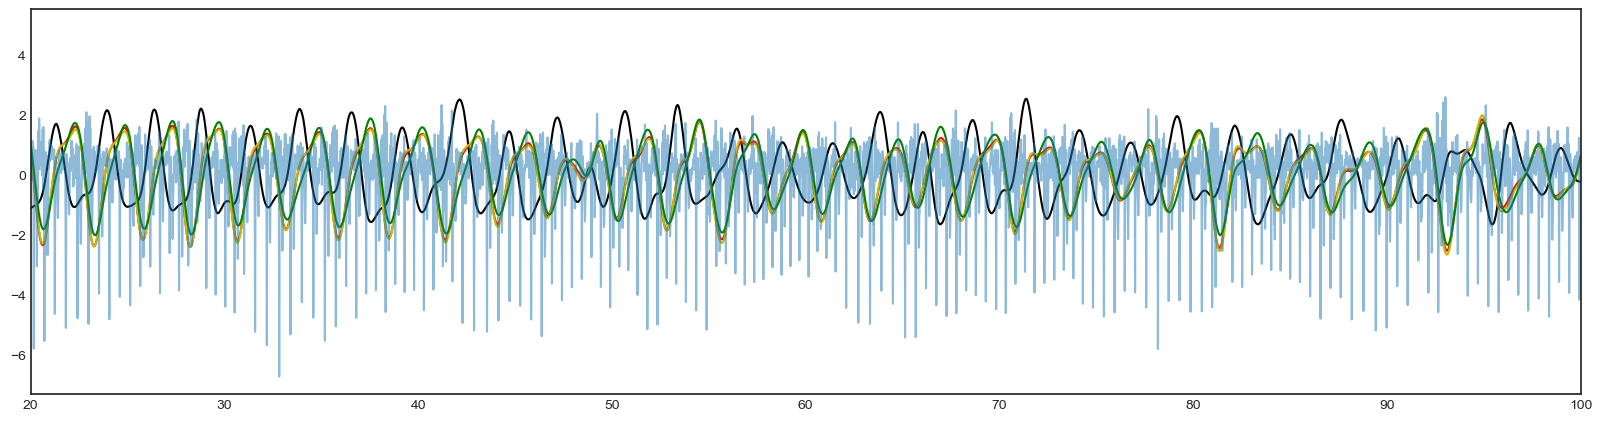

In [47]:



# ppg_r_2 = ppg_r_2 / get_smooth(ppg_r_2, N=FS_RESAMPLE*2)
# ppg_g_2 = ppg_g_2 / get_smooth(ppg_g_2, N=FS_RESAMPLE*2)
# ppg_ir_2 = ppg_ir_2 / get_smooth(ppg_ir_2, N=FS_RESAMPLE*2)


# X = 3 * ppg_g_2 - 2 * ppg_r_2
# Y = 1.5 * ppg_g_2 + ppg_r_2 - 1.5 * ppg_ir_2
# sigma = np.std(X) / np.std(Y)
# S = X - sigma * Y

# S = get_padded_filt(S, lowcutoff=FILT_PPG[0], highcutoff=FILT_PPG[1], Fs=FS_RESAMPLE)/S


# ppg_r_2 = get_padded_filt(ppg_r_2, lowcutoff=FILT_RESP[0], highcutoff=FILT_RESP[1], Fs=FS_RESAMPLE)/ppg_r_2
# ppg_ir_2 = get_padded_filt(ppg_ir_2, lowcutoff=FILT_RESP[0], highcutoff=FILT_RESP[1], Fs=FS_RESAMPLE)/ppg_ir_2


plt.figure(figsize=(20,5))
# plt.plot(time, ppg_diff/ppg_diff.std(), color='black')
plt.plot(time, S/S.std(), color='black')
plt.plot(time, ppg_r_2/ppg_r_2.std(), color='r')
plt.plot(time, ppg_ir_2/ppg_ir_2.std(), color='y')
plt.plot(time, ppg_g_2/ppg_g_2.std(), color='g')
plt.plot(time, ECG/ECG.std(), alpha=0.5)
# plt.plot(time, ppg_r_2)
# plt.plot(time, ppg_ir_2)
plt.xlim(20,100)
# plt.ylim(-0.0005,0.0005)
# plt.plot(ppg_ir_2)

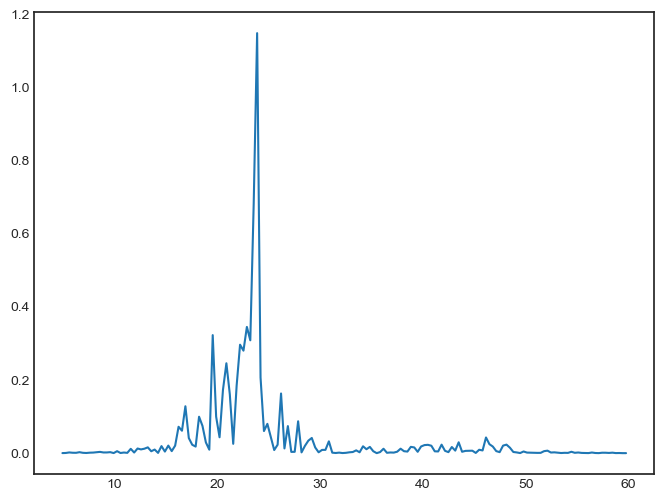

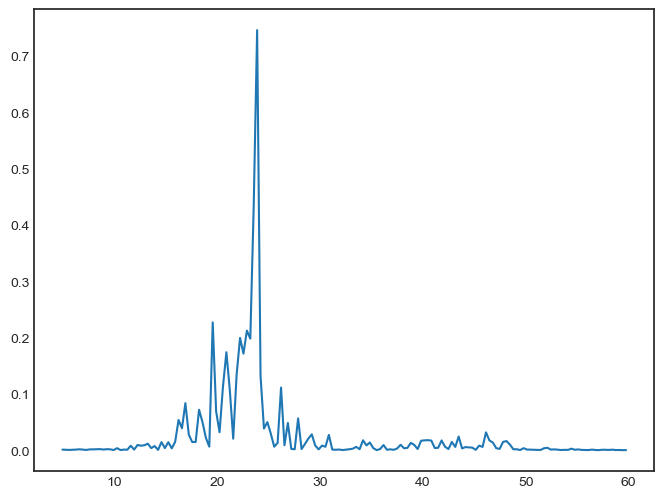

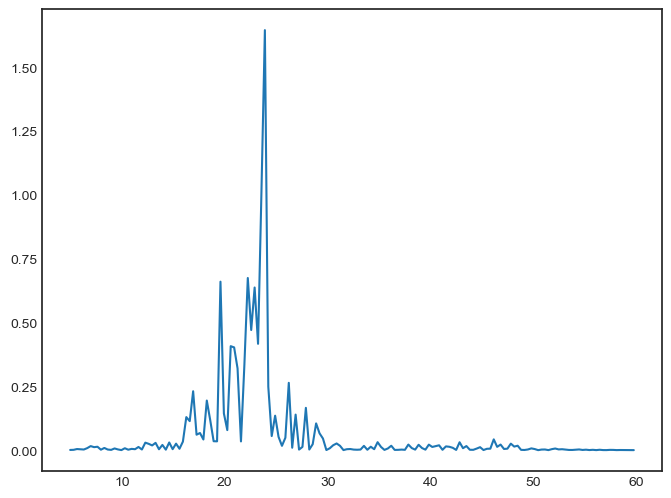

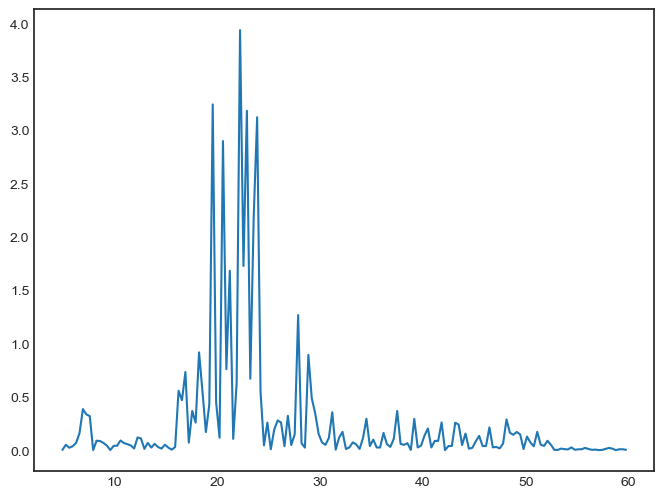

In [48]:

for sig in [ppg_r_2, ppg_ir_2, ppg_g_2, S]:
    xf, yf = get_psd(sig, FS_RESAMPLE)
    mask = (xf>=lowcutoff) & (xf<=highcutoff)
    xf = xf * 60
    xf, yf = xf[mask], yf[mask]

    plt.figure(figsize=(8,6))
    plt.plot(xf, yf)

	 use S peaks
	 use S peaks


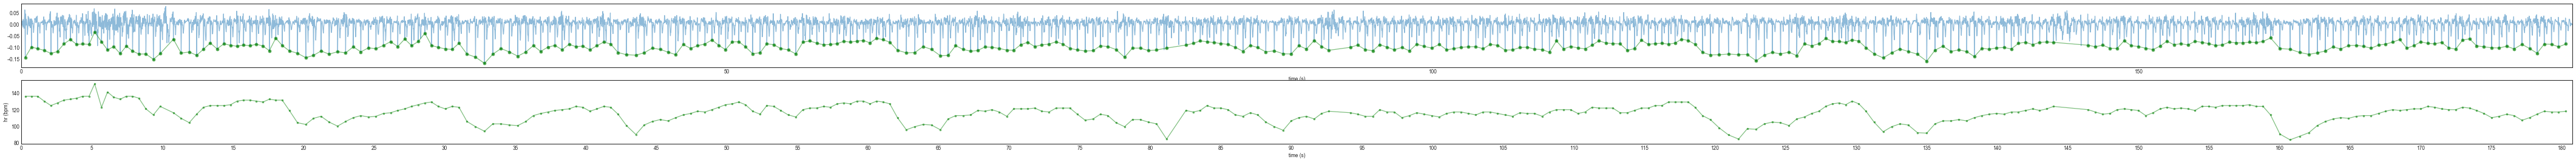

In [49]:
QRS_detector_dict_diagnostics

QRS_detector_dict = task_HR_detector(ECG, FS_RESAMPLE, beat_choice='i_S_peaks')

i_S_peaks = QRS_detector_dict['i_S_peaks']

In [50]:
QRS_detector_dict['hr'].mean()

116.40548886911702

In [51]:
ECG_beats, _ = beat_segmentation(ECG, i_S_peaks,start_offset=-50, end_offset=100)

ppg_r_2_beats, _ = beat_segmentation(ppg_r_2, i_S_peaks, start_offset=-50, end_offset=100)

ppg_ir_2_beats, _ = beat_segmentation(ppg_ir_2, i_S_peaks, start_offset=-50, end_offset=100)

ppg_g_2_beats, _ = beat_segmentation(ppg_g_2, i_S_peaks, start_offset=-50, end_offset=100)

# ppg_diff_beats, _ = beat_segmentation(ppg_diff, i_S_peaks, start_offset=-50, end_offset=100)

# ppg_diff2_beats, _ = beat_segmentation(ppg_diff2, i_S_peaks, start_offset=-50, end_offset=100)

# ppg_diff3_beats, _ = beat_segmentation(ppg_diff3, i_S_peaks, start_offset=-50, end_offset=100)

S_beats, _ = beat_segmentation(S, i_S_peaks, start_offset=-50, end_offset=100)


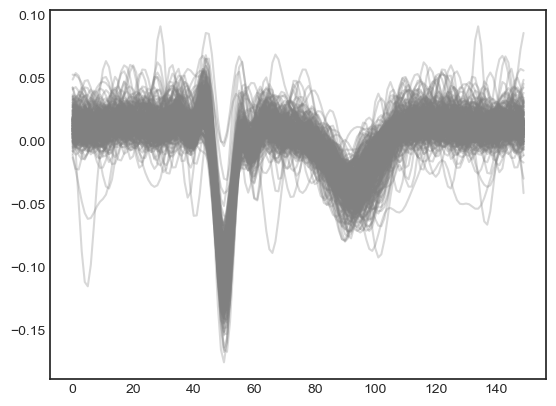

In [52]:
plt.plot(ECG_beats, alpha=0.3, color='gray')
plt.show()

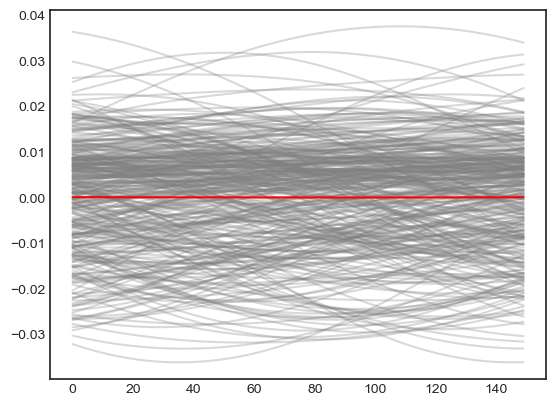

In [53]:
plt.plot(ppg_r_2_beats, color='gray', alpha=0.3)
plt.plot(ppg_r_2_beats.mean(axis=-1), color='red', )
# plt.ylim(-0.001, 0.001)
plt.show()

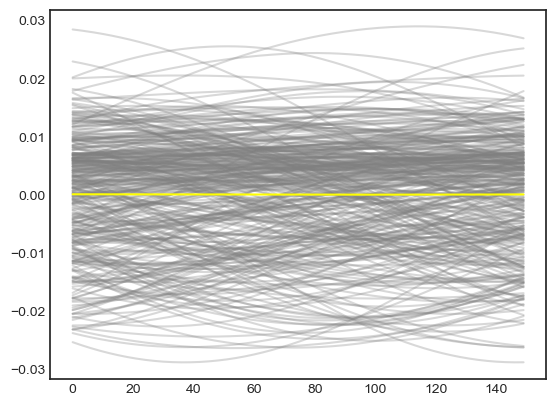

In [54]:
plt.plot(ppg_ir_2_beats, color='gray', alpha=0.3)
plt.plot(ppg_ir_2_beats.mean(axis=-1), color='yellow', )
# plt.ylim(-0.001, 0.001)
plt.show()

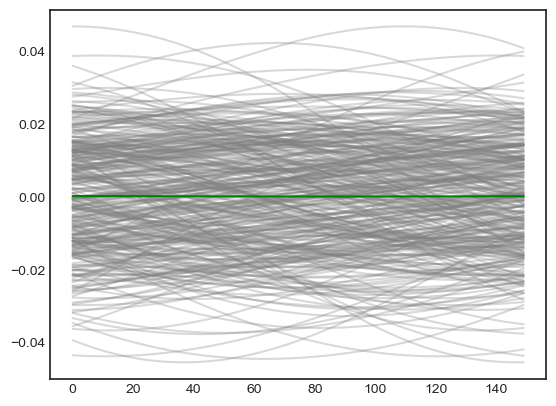

In [55]:
plt.plot(ppg_g_2_beats, color='gray', alpha=0.3)
plt.plot(ppg_g_2_beats.mean(axis=-1), color='green', )
# plt.ylim(-0.001, 0.001)
plt.show()

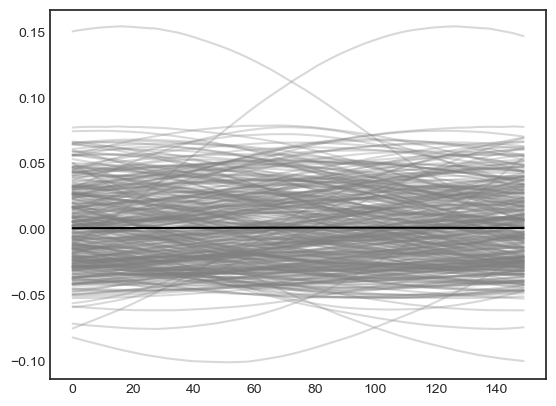

In [56]:
plt.plot(S_beats, color='gray', alpha=0.3)
plt.plot(S_beats.mean(axis=-1), color='black', )
# plt.ylim(-0.001, 0.001)
plt.show()

# comptue RQ_cal

## 1. get Rnormed_cosmed: squeeze R_cosmed to be between 0.7-1
## 2. get RQ_calories: convert R (respiratory quotient) to Caloric Equivalent of Oxygen (kcals/liter) -> (kcals/ml)	
## 3. get EErq_cosmed (this is the EE computed using VO2 alone): RQ_calories [kcal/ml of O2] * VO2 [ml/min] = EE in [kcal/min]

In [57]:
df_RQ_cal = pd.read_csv('../../data/raw/Caloric Equivalent of Oxygen at Different RQ.csv')

In [58]:
df_RQ_cal

Respiratory Quotient  Caloric Equivalent of Oxygen (kcals/liter)  Fat (%)  \
0                   0.70                                        4.60    100.0   
1                   0.71                                        4.62     96.7   
2                   0.72                                        4.63     93.3   
3                   0.73                                        4.64     90.0   
4                   0.74                                        4.66     86.7   
5                   0.75                                        4.68     83.3   
6                   0.76                                        4.69     80.0   
7                   0.77                                        4.71     76.7   
8                   0.78                                        4.72     73.3   
9                   0.79                                        4.74     70.0   
10                  0.80                                        4.75     66.7   
11                  0.81                                        4.77     63.3   
12                  0.82                                        4.78     60.0   
13                  0.83                                        4.80     56.7   
14                  0.84                                        4.81     53.3   
15                  0.85                                        4.83     50.0   
16                  0.86                                        4.84     46.7   
17                  0.87                                        4.86     43.3   
18                  0.88                                        4.87     40.0   
19                  0.89                                        4.89     36.7   
20                  0.90                                        4.90     33.3   
21                  0.91                                        4.92     30.0   
22                  0.92                                        4.93     26.7   
23                  0.93                                        4.95     23.3   
24                  0.94                                        4.96     20.0   
25                  0.95                                        4.98     16.7   
26                  0.96                                        4.99     13.3   
27                  0.97                                        5.01     10.0   
28                  0.98                                        5.02      6.7   
29                  0.99                                        5.04      3.3   
30                  1.00                                        5.05      0.0   

    Carbohydrate (%)  
0                0.0  
1                3.3  
2                6.7  
3               10.0  
4               13.3  
5               16.7  
6               20.0  
7               23.3  
8               26.7  
9               30.0  
10              33.3  
11              36.7  
12              40.0  
13              43.3  
14              46.7  
15              50.0  
16              53.3  
17              56.7  
18              60.0  
19              63.3  
20              66.7  
21              70.0  
22              73.3  
23              76.7  
24              80.0  
25              83.3  
26              86.7  
27              90.0  
28              93.3  
29              96.7  
30             100.0

In [59]:
# get f_RQinterp first
f_RQinterp = interp1d(df_RQ_cal['Respiratory Quotient'].values, df_RQ_cal['Caloric Equivalent of Oxygen (kcals/liter)'].values)

check_RQinterp = False
if check_RQinterp:

    x = np.linspace(0.7, 1., 100)

    plt.scatter(df_RQ_cal['Respiratory Quotient'].values, df_RQ_cal['Caloric Equivalent of Oxygen (kcals/liter)'].values)
    plt.plot(x, f_RQinterp(x))

In [60]:
# convert R to Rnormed
df_sync['Rnormed_cosmed'] = df_sync['K5_R_cosmed'].copy()
df_sync.loc[df_sync['Rnormed_cosmed'] > 1, 'Rnormed_cosmed'] = 1
df_sync.loc[df_sync['Rnormed_cosmed'] < 0.7, 'Rnormed_cosmed'] = 0.7

# get RQ_calories
df_sync['RQ_calories'] = f_RQinterp(df_sync['Rnormed_cosmed'].values)/1000

# get EErq_cosmed [kcal/min]
df_sync['EErq_cosmed'] = df_sync['RQ_calories'] * df_sync['VO2_cosmed']


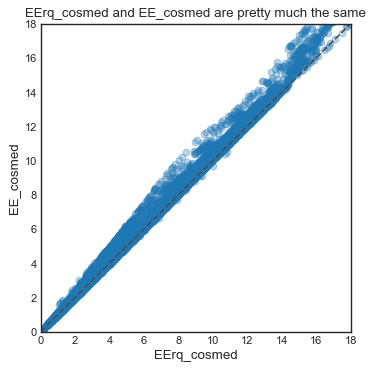

In [61]:
check_EErq = True
if check_EErq:
    fig, ax = plt.subplots(1,1,figsize=(5,5), dpi=80)

    ax.scatter(df_sync[df_sync['Sampled_cosmed']==1]['EErq_cosmed'], df_sync[df_sync['Sampled_cosmed']==1]['EE_cosmed'], alpha=0.3)
    ax.plot([0,18], [0,18], ls="--", c=".3")

    ax.set_xlabel('EErq_cosmed', fontsize=12)
    ax.set_ylabel('EE_cosmed', fontsize=12)
    ax.set_title('EErq_cosmed and EE_cosmed are pretty much the same', fontsize=12)
    ax.set_xlim(0,18)
    ax.set_ylim(0,18)

In [62]:
df_sync

HR_cosmed  RR_cosmed  VT_cosmed  VE_cosmed  FeO2_cosmed  \
0          81.566133  15.381147   905.7216   12639.36    16.348115   
1          81.566400  15.382240   905.6608   12639.68    16.348224   
2          81.566667  15.383333   905.6000   12640.00    16.348333   
3          81.566933  15.384427   905.5392   12640.32    16.348443   
4          81.567200  15.385520   905.4784   12640.64    16.348552   
...              ...        ...        ...        ...          ...   
12556019  112.186400  47.456000  1663.1744   78691.04    17.369120   
12556020  112.188800  47.452000  1663.0848   78679.68    17.369040   
12556021  112.191200  47.448000  1662.9952   78668.32    17.368960   
12556022  112.193600  47.444000  1662.9056   78656.96    17.368880   
12556023  112.196000  47.440000  1662.8160   78645.60    17.368800   

          FeCO2_cosmed  FiO2_cosmed  FiCO2_cosmed  VO2_cosmed  VCO2_cosmed  \
0             3.806773        20.93          0.04    493.5460   397.471867   
1             3.806720        20.93          0.04    493.5480   397.477600   
2             3.806667        20.93          0.04    493.5500   397.483333   
3             3.806613        20.93          0.04    493.5520   397.489067   
4             3.806560        20.93          0.04    493.5540   397.494800   
...                ...          ...           ...         ...          ...   
12556019      4.187288        20.93          0.04   2146.2216  2625.484800   
12556020      4.187296        20.93          0.04   2145.9472  2625.081600   
12556021      4.187304        20.93          0.04   2145.6728  2624.678400   
12556022      4.187312        20.93          0.04   2145.3984  2624.275200   
12556023      4.187320        20.93          0.04   2145.1240  2623.872000   

          EE_cosmed  SPO2_cosmed  GpsAlt_cosmed  AmbTemp_cosmed  \
0          2.385765      95.8000        304.746         24.5000   
1          2.385779      95.8000        304.748         24.5000   
2          2.385793      95.8000        304.750         24.5000   
3          2.385808      95.8000        304.752         24.5000   
4          2.385822      95.8000        304.754         24.5000   
...             ...          ...            ...             ...   
12556019  11.370401      94.7288        294.000         24.9256   
12556020  11.368873      94.7296        294.000         24.9152   
12556021  11.367344      94.7304        294.000         24.9048   
12556022  11.365815      94.7312        294.000         24.8944   
12556023  11.364286      94.7320        294.000         24.8840   

          Battery_cosmed  K5_R_cosmed      time  Marker_cosmed      task  \
0                   83.0     0.782984    93.492            0.0  Baseline   
1                   83.0     0.782992    93.496            0.0  Baseline   
2                   83.0     0.783000    93.500            0.0  Baseline   
3                   83.0     0.783008    93.504            0.0  Baseline   
4                   83.0     0.783016    93.508            0.0  Baseline   
...                  ...          ...       ...            ...       ...   
12556019            58.0     1.216848  4991.644            0.0       Run   
12556020            58.0     1.216816  4991.648            0.0       Run   
12556021            58.0     1.216784  4991.652            0.0       Run   
12556022            58.0     1.216752  4991.656            0.0       Run   
12556023            58.0     1.216720  4991.660            0.0       Run   

          Sampled_cosmed       ECG    accelX    accelY    accelZ      ppg_g_1  \
0                    0.0 -0.063972 -0.103710  0.964706  0.269084   539.076299   
1                    0.0  0.005749 -0.106476  0.965272  0.264052   539.291790   
2                    0.0  0.035875 -0.108415  0.970055  0.270883   539.507281   
3                    0.0  0.050544 -0.108208  0.975567  0.281688   539.669780   
4                    0.0  0.051450 -0.107400  0.979754  0.280956   539.787146   
...                  ...     

In [63]:
# df_subinfo

# inspect the error of EE label

In [64]:

def get_estimated_label(df_sync, df_subinfo, subject_id_val, feature_names=['Weight'], label_name='EErq_cosmed'):
    # this function estimate the `label_name` using the weight of the subject
    # weight is used because basal metabolic rate is usually estimated well using this demographic info
    
    # the demographic data
    df_A = df_subinfo[['Subject_ID', 'Weight', 'Height', 'Gender_encoded']]
    df_A = df_A.rename(columns={"Subject_ID": "subject_id"})
    
    # the cosmed data
    df_B = df_sync[(df_sync['task']=='Baseline') & (df_sync['Sampled_cosmed']==1)].copy()[[label_name, 'subject_id']]
    df_merged = df_A.merge(df_B, on=['subject_id'])
    

    # split data into train and val (LOSO)
#     feature_train = df_merged[df_merged['subject_id']!=subject_id_val][['Weight', 'Height', 'Gender_encoded']].values
#     feature_val = df_merged[df_merged['subject_id']==subject_id_val][['Weight', 'Height', 'Gender_encoded']].values
    feature_train = df_merged[df_merged['subject_id']!=subject_id_val][feature_names].values
    feature_val = df_merged[df_merged['subject_id']==subject_id_val][feature_names].values

    label_train = df_merged[df_merged['subject_id']!=subject_id_val][label_name].values[:,None]
    label_val = df_merged[df_merged['subject_id']==subject_id_val][label_name].values[:,None]

    
    # use linear regression to fit and predict
    model = LinearRegression()

    model = model.fit(feature_train, label_train)
    label_est_train = model.predict(feature_train)
    label_est_val = model.predict(feature_val)

    # get a single value using mean (label_est_val and label_val should have a constant values anyway)
    label_est_val = label_est_val.mean()
    label_val = label_val.mean()
    
    return label_est_val, label_val

In [65]:
df_label_baseline = pd.DataFrame()

for subject_id in df_sync['subject_id'].unique():
    # # get the subject data during baseline, using cosmed sample timestamps only
    df_task = df_sync[(df_sync['subject_id']==subject_id) & (df_sync['task']=='Baseline') & (df_sync['Sampled_cosmed']==1)].copy()

    # compute the mean during baseline
    EE_baseline = df_task['EE_cosmed'].mean()
    VO2_baseline = df_task['VO2_cosmed'].mean()
    VT_baseline = df_task['VT_cosmed'].mean()
    VE_baseline = df_task['VE_cosmed'].mean()
    weight = df_subinfo[df_subinfo['Subject_ID']==subject_id]['Weight'].values[0]
    BMR = df_subinfo[df_subinfo['Subject_ID']==subject_id]['BMR'].values[0]

    # estimate using weight
    EErq_est_val, EErq_val = get_estimated_label(df_sync, df_subinfo, subject_id, feature_names=['Weight'], label_name='EErq_cosmed')
    VT_est_val, VT_val = get_estimated_label(df_sync, df_subinfo, subject_id, feature_names=['Weight'], label_name='VT_cosmed')
    VO2_est_val, VO2_val = get_estimated_label(df_sync, df_subinfo, subject_id, feature_names=['Weight'], label_name='VO2_cosmed')
    VE_est_val, VE_val = get_estimated_label(df_sync, df_subinfo, subject_id, feature_names=['Weight'], label_name='VE_cosmed')

# def get_estimated_label(df_sync, df_subinfo, subject_id_val, label_name='EErq_cosmed'):

    df_label_baseline = df_label_baseline.append(
    pd.DataFrame( {
        'subject_id': [int(subject_id)],
        'EE_baseline': [EE_baseline],
        'VO2_baseline': [VO2_baseline],
        'VT_baseline': [VT_baseline],
        'VE_baseline': [VE_baseline],
        'weight': [weight],
        'BMR': [BMR],
        
        'EErq_val': [EErq_val],
        'VT_val': [VT_val],
        'VO2_val': [VO2_val],
        'VE_val': [VE_val],
        
        'EErq_est_val': [EErq_est_val],
        'VT_est_val': [VT_est_val],
        'VO2_est_val': [VO2_est_val],
        'VE_est_val': [VE_est_val],
#         'BMRavg_est_val': [BMRavg_est_val],
#         'BMRavg_val': [BMRavg_val],
    }), ignore_index=True )


In [66]:
est_label_names = ['EErq', 'VT', 'VO2','VE']

In [67]:
def label_point(x, y, val, ax, fontsize=3):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(int(point['val'])), fontsize=fontsize)



MAE of EErq: 0.43
R2 of EErq: 0.23
PCC of EErq: 0.52

MAE of VT: 185.14
R2 of VT: 0.26
PCC of VT: 0.53

MAE of VO2: 90.41
R2 of VO2: 0.21
PCC of VO2: 0.50

MAE of VE: 2251.46
R2 of VE: 0.14
PCC of VE: 0.41


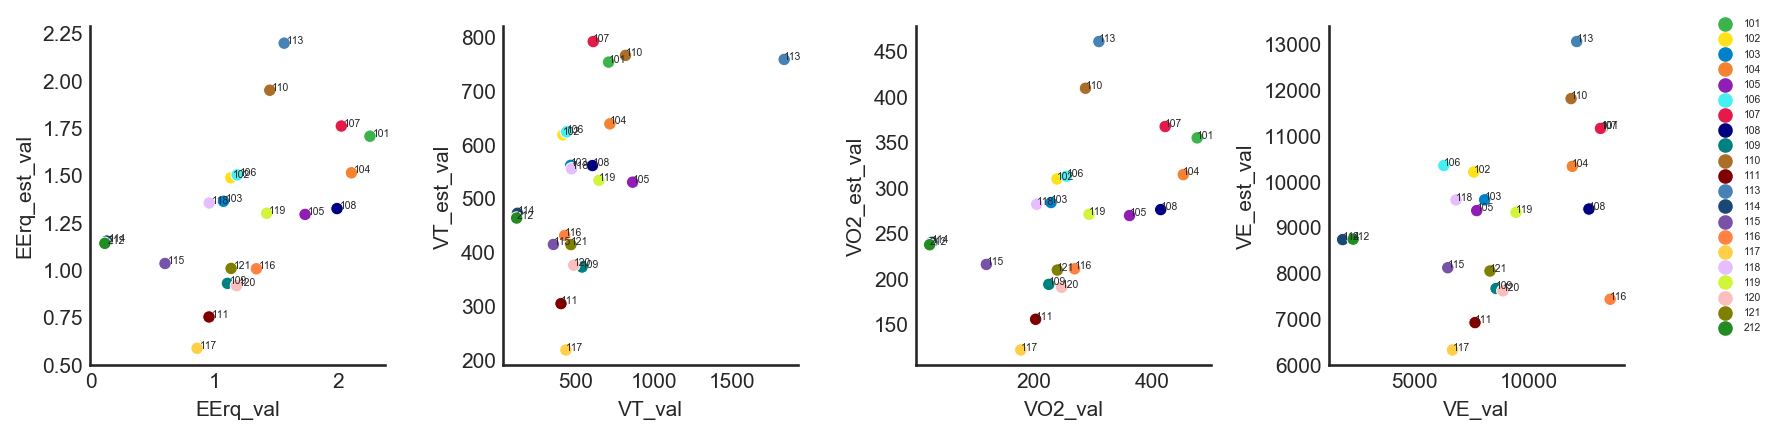

In [68]:

fig, axes = plt.subplots(1, len(est_label_names), figsize=(3*len(est_label_names), 3), dpi=150)

for ax, est_label_name in zip(axes, est_label_names):
    x_name = est_label_name+'_val'
    y_name = est_label_name+'_est_val'
    sns.scatterplot(ax=ax, data=df_label_baseline, x=x_name, y=y_name, hue='subject_id', palette=subject_palette)
    label_point(df_label_baseline[x_name], df_label_baseline[y_name], df_label_baseline['subject_id'], ax, fontsize=5)

    MAE, _ = get_MAE(df_label_baseline[est_label_name+'_val'], df_label_baseline[est_label_name+'_est_val'])
    R2 = get_CoeffDeterm(df_label_baseline[est_label_name+'_val'], df_label_baseline[est_label_name+'_est_val'])
    PCC = get_PCC(df_label_baseline[est_label_name+'_val'], df_label_baseline[est_label_name+'_est_val'])
    print('\nMAE of {}: {:.2f}'.format(est_label_name, MAE))
    print('R2 of {}: {:.2f}'.format(est_label_name, R2))
    print('PCC of {}: {:.2f}'.format(est_label_name, PCC))



for ax in axes:
    # ax.set_xlim(xmin, xmax)
    ax_no_top_right(ax)
    ax.legend([],[], frameon=False)
    
ax.legend( bbox_to_anchor=(1.5, 1.05), fontsize=5)

fig.tight_layout()
    
# # for label_name in est_label_names:
    
# #      fig, axes = 
# # ax = sns.scatterplot(data=df_label_baseline, x='EEavg_val', y='EEavg_est_val', hue='subject_id', palette=subject_palette)
# # ax.legend(loc='upper right')
 
# MAE, _ = get_MAE(df_label_baseline['EEavg_val'], df_label_baseline['EEavg_est_val'])
# MAE

# simulate resp. sig

In [69]:
def get_RRVT2resp(df_task, Fs):
    f_arr_raw = df_task['RR_cosmed'].values/60
    t_arr = np.arange(df_task.shape[0])/Fs
    # smooth it since it's usally digital and disgusting
    f_arr = get_smooth(f_arr_raw, N=Fs*5)
    # v_arr is the simulated sinusoidal breath signal, sampled eqaully as t_arr
    v_arr, f_sim_interp = get_sim_breath(t_arr, f_arr, downsample_factor=Fs//5) # Fs=500Hz
    resp_cosmed = v_arr*df_task['VT_cosmed']/2

    return resp_cosmed, v_arr

# add HR_patch, resp_cosmed, O2pulse_cosmedpatch, CO_patchsur, SCG spectral features, SCG statistical features
# extract resp signals

In [70]:
df_sync['task'].unique()

array(['Baseline', 'Recovery 6MWT', 'Recovery 6MWT-R',
       'Recovery StairDown1', 'Recovery Walk', 'Recovery Run', '6MWT',
       '6MWT-R', 'StairDown0', 'StairUp0', 'StairDown1', 'Walk', 'Run'],
      dtype=object)

In [71]:
df_sub['task'].unique()

array(['Transition', 'Baseline 0', 'Standing 0', 'Proning 0', 'LL 0',
       'LR 0', 'Cough 0', 'SpeakCasual 0', 'SpeakScripted 0', '6MWT 0',
       'Recovery 0', '6MWT-R 0', 'Recovery 1', 'StairDown0', 'StairUp0',
       'StairDown1', 'Recovery 2', 'Cough 1', 'SpeakCasual 1',
       'SpeakScripted 1', 'Walk 0', 'Recovery 3', 'Run 0', 'Recovery 4'],
      dtype=object)

# filter_DFcolumns will extract the following columns:

## `ECG_filt`
## `accelX_filt`, `accelY_filt`, `accelZ_filt`

## `scgX`, `scgY`, `scgZ`

## `ppg_g_1_cardiac`, `ppg_g_2_cardiac`, `ppg_r_1_cardiac`, `ppg_r_2_cardiac`, `ppg_ir_1_cardiac`, `ppg_ir_2_cardiac`
## `ppg_g_1_resp`, `ppg_g_2_resp`, `ppg_r_1_resp`, `ppg_r_2_resp`, `ppg_ir_1_resp`, `ppg_ir_2_resp`


In [72]:
df_task.keys()

Index(['HR_cosmed', 'RR_cosmed', 'VT_cosmed', 'VE_cosmed', 'FeO2_cosmed',
       'FeCO2_cosmed', 'FiO2_cosmed', 'FiCO2_cosmed', 'VO2_cosmed',
       'VCO2_cosmed', 'EE_cosmed', 'SPO2_cosmed', 'GpsAlt_cosmed',
       'AmbTemp_cosmed', 'Battery_cosmed', 'K5_R_cosmed', 'time',
       'Marker_cosmed', 'task', 'Sampled_cosmed', 'ECG', 'accelX', 'accelY',
       'accelZ', 'ppg_g_1', 'ppg_r_1', 'ppg_ir_1', 'ppg_g_2', 'ppg_r_2',
       'ppg_ir_2', 'temp_skin', 'pres', 'OUES_cosmed', 'subject_id',
       'Rnormed_cosmed', 'RQ_calories', 'EErq_cosmed'],
      dtype='object')

In [73]:
# # df_task['scgXYZ'] = 



# t = df_task['time'].values
# t = t - t.min()

# plt.figure(figsize=(20,3))
# plt.plot(t, scgX, 'r')
# plt.plot(t, scgY, 'b')
# plt.plot(t, scgZ, 'y')
# plt.plot(t, scgXYZ, 'g')
# plt.xlim(5,8)

In [74]:
df_sync_extracted = pd.DataFrame()

NF_dict_subs = {}

include_spectral = True

for subject_id in df_sync['subject_id'].unique():
#     if subject_id!='101':
#         continue
    df_sub = df_sync[df_sync['subject_id']==subject_id]
    outputdir_sub = outputdir+subject_id+'/'
    
    for task_name in df_sub['task'].unique():
        # if task_name!='6MWT-R':
        #     continue
        print('sub: {}, task: {}'.format(subject_id, task_name))
    
        # 1. get df_task (data of a subject, a task)
        df_task = df_sub[df_sub['task']==task_name].copy()
        df_task = df_task.reset_index(drop=True)
        
        # 2. get QRS from ECG
        ECG_raw_patch = df_task['ECG'].values
        # fig_name = 'ECG_diagnostics_'+task_name + 
        fig_name = subject_id
        # QRS_detector_dict_patch = task_HR_detector(ECG_raw_patch, Fs, beat_choice='i_S_peaks',  fig_name=fig_name, outputdir=outputdir_sub, show_plot=True)
        QRS_detector_dict_patch = task_HR_detector(ECG_raw_patch, Fs, beat_choice='i_beat_peaks',  fig_name=fig_name, outputdir=outputdir_diagnostic + 'ECG_diag/{}/'.format(task_name), show_plot=True)

        # 3. get simulated resp. signal
        resp_cosmed, br_sim_sig = get_RRVT2resp(df_task, Fs)

        # 4. extract HR
        t_sig = np.arange(ECG_raw_patch.shape[0])/Fs
        hr_interp = np.interp(t_sig, QRS_detector_dict_patch['ts_hr'], QRS_detector_dict_patch['hr'])
        # remove respiratory modulation on HR (is this necesary?)
        hr_interp = get_padded_filt_DSwrapper(hr_interp, filter_padded=5, lowcutoff=None, highcutoff=0.05, Fs=Fs)
#         hr_interp = get_padded_filt(hr_interp, filter_padded=1, lowcutoff=FILT_RESP[0], highcutoff=FILT_RESP[1], Fs=Fs)
        
        # 5. Filter the signals
        df_task = filter_DFcolumns(df_task.copy(), Fs)
        
        # 6. extract normalizing factor
        if task_name=='Baseline':
            if training_params['signal_normalization']=='zeromean_unitvar': # Make baseline zero mean and unit variance. Make other segments normalized to the baseline mean and var
                Nf_dict = get_Nf_dict2(df_task, QRS_detector_dict_patch, Fs)
            elif training_params['signal_normalization']=='respmod_baseline': # compute the respiratory modulation range of each signals during baseline. Divide the signal by this range
                Nf_dict = get_Nf_dict(df_task, QRS_detector_dict_patch, Fs)
            elif training_params['signal_normalization']=='none':
                Nf_dict = get_Nf_dict3(df_task, QRS_detector_dict_patch, Fs)
                
            NF_dict_subs[subject_id] = Nf_dict
    
        # 7. normalize the physiological signals
        for sig_name in Nf_dict: # 'ECG', 'accelZ', 'ppg_g_1_cardiac', 'ppg_g_2_cardiac', 'ppg_r_1_cardiac', 'ppg_r_2_cardiac', 'ppg_ir_1_cardiac', 'ppg_ir_2_cardiac'
            df_task[sig_name] = df_task[sig_name] / Nf_dict[sig_name]
#         print(Nf_dict)

        # 8. get O2 pulse
        O2pulse_cosmedpatch = df_task['VO2_cosmed']/hr_interp

        # [9]. assign these features to the dataframe
        df_task['HR_patch'] = hr_interp # extracted from ECG
        df_task['resp_cosmed'] = resp_cosmed # reconstructed from cosmed TV and RR
        df_task['br_sim_sig'] = br_sim_sig # reconstructed from cosmed TV and RR
        df_task['O2pulse_cosmedpatch'] = O2pulse_cosmedpatch

        # [10]. assign spectral features and assign them to the df
        if include_spectral:
            # i_peaks = QRS_detector_dict_patch['i_{}_peaks'.format(QRS_detector_dict_patch['use_R_S'])]
            i_peaks = QRS_detector_dict_patch['i_beat_peaks']
            
            

            scgX = get_padded_filt(df_task['accelX'].values, lowcutoff=FILT_SCG[0], highcutoff=FILT_SCG[1], Fs=FS_RESAMPLE)
            scgY = get_padded_filt(df_task['accelY'].values, lowcutoff=FILT_SCG[0], highcutoff=FILT_SCG[1], Fs=FS_RESAMPLE)
            scgZ = get_padded_filt(df_task['accelZ'].values, lowcutoff=FILT_SCG[0], highcutoff=FILT_SCG[1], Fs=FS_RESAMPLE)

            scgXYZ = np.sqrt(scgX**2 + scgY**2 + scgZ**2)
            df_task['scgXYZ'] = scgXYZ
                
            
            for accel_name in ['accelX', 'accelY', 'accelZ', 'scgXYZ']:
                # features_spectral = get_spectral_features(df_task, i_peaks, accel_name=accel_name, Fs=Fs)
                features_spectral = get_spectral_features(df_task, i_peaks, accel_name=accel_name, Fs=Fs, smoothen_feature=False)

                for key, value in features_spectral.items():
                    df_task[key] = value
                

                
                
        # [11]. assign cardiac output surrogate
        df_task['scgX_CO'] = df_task['scgX_std'].values * df_task['HR_patch'].values
        df_task['scgY_CO'] = df_task['scgY_std'].values * df_task['HR_patch'].values
        df_task['scgZ_CO'] = df_task['scgZ_std'].values * df_task['HR_patch'].values
        df_task['scgXYZ_CO'] = df_task['scgXYZ_std'].values * df_task['HR_patch'].values

        # 12. inspect extracted features
        fig_name = subject_id
        # fig_name = 'physio_diagnostics_'+task_name
        plot_inputsigs(df_task, Fs, fig_name=fig_name, outputdir=outputdir_diagnostic + 'signals_diag/{}/'.format(task_name), show_plot=False)
        
        # 13. add the processed data to the new dataframe
        df_sync_extracted = df_sync_extracted.append(df_task.copy())
#         print(task_name)



sub: 101, task: Baseline
	 use S peaks
	 use S peaks
		 [SCG beats] reject 10.13% of the beats
		 [SCG beats] reject 8.02% of the beats
		 [SCG beats] reject 7.59% of the beats
		 [SCG beats] reject 10.55% of the beats
sub: 101, task: Recovery 6MWT
	 use S peaks
	 use S peaks
		 [SCG beats] reject 11.61% of the beats
		 [SCG beats] reject 12.50% of the beats
		 [SCG beats] reject 17.41% of the beats
		 [SCG beats] reject 16.96% of the beats
sub: 101, task: Recovery 6MWT-R
	 use S peaks
	 use S peaks
		 [SCG beats] reject 8.71% of the beats
		 [SCG beats] reject 4.15% of the beats
		 [SCG beats] reject 6.22% of the beats
		 [SCG beats] reject 7.05% of the beats
sub: 101, task: Recovery StairDown1
	 use S peaks
	 use S peaks
		 [SCG beats] reject 4.04% of the beats
		 [SCG beats] reject 4.48% of the beats
		 [SCG beats] reject 3.59% of the beats
		 [SCG beats] reject 5.38% of the beats
sub: 101, task: Recovery Walk
	 use S peaks
	 use S peaks
		 [SCG beats] reject 12.45% of the beats
		 

../PatchWand/stage3_preprocess.py:271: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


sub: 103, task: Walk
	 use S peaks
	 use S peaks
		 [SCG beats] reject 63.20% of the beats
		 [SCG beats] reject 16.16% of the beats
		 [SCG beats] reject 15.08% of the beats
		 [SCG beats] reject 5.75% of the beats
sub: 103, task: Run
	 use S peaks
	 use S peaks
		 [SCG beats] reject 79.57% of the beats
		 [SCG beats] reject 0.00% of the beats
		 [SCG beats] reject 83.41% of the beats
		 [SCG beats] reject 6.97% of the beats
sub: 104, task: Baseline
	 use S peaks
	 use S peaks
		 [SCG beats] reject 0.00% of the beats
		 [SCG beats] reject 7.52% of the beats
		 [SCG beats] reject 2.26% of the beats
		 [SCG beats] reject 2.26% of the beats
sub: 104, task: Recovery 6MWT-R
	 use S peaks
	 use S peaks
		 [SCG beats] reject 16.34% of the beats
		 [SCG beats] reject 21.01% of the beats
		 [SCG beats] reject 38.13% of the beats
		 [SCG beats] reject 17.90% of the beats
sub: 104, task: Recovery 6MWT
	 use S peaks
	 use S peaks
		 [SCG beats] reject 5.90% of the beats
		 [SCG beats] reject 13.6

../PatchWand/stage3_preprocess.py:271: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


sub: 104, task: Walk
	 use S peaks
	 use S peaks
		 [SCG beats] reject 93.98% of the beats
		 [SCG beats] reject 44.06% of the beats
		 [SCG beats] reject 97.15% of the beats
		 [SCG beats] reject 39.94% of the beats
sub: 104, task: Run
	 use S peaks
	 use S peaks
		 [SCG beats] reject 98.45% of the beats
		 [SCG beats] reject 0.00% of the beats
		 [SCG beats] reject 9.59% of the beats
		 [SCG beats] reject 3.11% of the beats
sub: 105, task: Baseline
	 use R peaks
	 use R peaks
		 [SCG beats] reject 3.79% of the beats
		 [SCG beats] reject 0.95% of the beats
		 [SCG beats] reject 0.00% of the beats
		 [SCG beats] reject 0.95% of the beats
sub: 105, task: Recovery 6MWT
	 use R peaks
	 use R peaks
		 [SCG beats] reject 44.13% of the beats
		 [SCG beats] reject 37.65% of the beats
		 [SCG beats] reject 16.60% of the beats
		 [SCG beats] reject 20.24% of the beats
sub: 105, task: Recovery 6MWT-R
	 use R peaks
	 use R peaks
		 [SCG beats] reject 30.00% of the beats
		 [SCG beats] reject 21.

../PatchWand/stage3_preprocess.py:271: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


sub: 105, task: StairUp0
	 use R peaks
	 use R peaks
		 [SCG beats] reject 91.18% of the beats
		 [SCG beats] reject 36.76% of the beats
		 [SCG beats] reject 36.76% of the beats
		 [SCG beats] reject 61.76% of the beats
sub: 105, task: StairDown1
	 use R peaks
	 use R peaks
		 [SCG beats] reject 72.41% of the beats
		 [SCG beats] reject 51.72% of the beats
		 [SCG beats] reject 68.97% of the beats
		 [SCG beats] reject 75.86% of the beats


../PatchWand/stage3_preprocess.py:271: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


sub: 105, task: Walk
	 use R peaks
	 use R peaks
		 [SCG beats] reject 62.66% of the beats
		 [SCG beats] reject 25.13% of the beats
		 [SCG beats] reject 75.58% of the beats
		 [SCG beats] reject 29.44% of the beats
sub: 105, task: Run
	 use R peaks
	 use R peaks
		 [SCG beats] reject 39.86% of the beats
		 [SCG beats] reject 0.00% of the beats
		 [SCG beats] reject 0.71% of the beats
		 [SCG beats] reject 0.00% of the beats
sub: 106, task: Baseline
	 use S peaks
	 use S peaks
		 [SCG beats] reject 10.04% of the beats
		 [SCG beats] reject 6.69% of the beats
		 [SCG beats] reject 17.84% of the beats
		 [SCG beats] reject 12.27% of the beats
sub: 106, task: Recovery 6MWT-R
	 use S peaks
	 use S peaks
		 [SCG beats] reject 20.00% of the beats
		 [SCG beats] reject 16.62% of the beats
		 [SCG beats] reject 9.01% of the beats
		 [SCG beats] reject 19.44% of the beats
sub: 106, task: Recovery 6MWT
	 use S peaks
	 use S peaks
		 [SCG beats] reject 45.91% of the beats
		 [SCG beats] reject 3

../PatchWand/stage3_preprocess.py:271: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


sub: 106, task: StairUp0
	 use S peaks
	 use S peaks
		 [SCG beats] reject 48.35% of the beats
		 [SCG beats] reject 9.89% of the beats
		 [SCG beats] reject 21.98% of the beats
		 [SCG beats] reject 58.24% of the beats
sub: 106, task: StairDown1
	 use S peaks
	 use S peaks
		 [SCG beats] reject 41.86% of the beats
		 [SCG beats] reject 83.72% of the beats
		 [SCG beats] reject 83.72% of the beats
		 [SCG beats] reject 97.67% of the beats


../PatchWand/stage3_preprocess.py:271: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


sub: 106, task: Walk
	 use S peaks
	 use S peaks
		 [SCG beats] reject 94.97% of the beats
		 [SCG beats] reject 18.75% of the beats
		 [SCG beats] reject 10.67% of the beats
		 [SCG beats] reject 6.55% of the beats
sub: 106, task: Run
	 use S peaks
	 use S peaks
		 [SCG beats] reject 100.00% of the beats
		 [SCG beats] reject 0.00% of the beats
		 [SCG beats] reject 0.24% of the beats
		 [SCG beats] reject 0.24% of the beats
sub: 107, task: Baseline
	 use S peaks
	 use S peaks
		 [SCG beats] reject 1.02% of the beats
		 [SCG beats] reject 1.02% of the beats
		 [SCG beats] reject 1.53% of the beats
		 [SCG beats] reject 1.53% of the beats
sub: 107, task: Recovery 6MWT-R
	 use S peaks
	 use S peaks
		 [SCG beats] reject 8.75% of the beats
		 [SCG beats] reject 10.27% of the beats
		 [SCG beats] reject 48.29% of the beats
		 [SCG beats] reject 14.07% of the beats
sub: 107, task: Recovery 6MWT
	 use S peaks
	 use S peaks
		 [SCG beats] reject 6.90% of the beats
		 [SCG beats] reject 12.07

../PatchWand/stage3_preprocess.py:271: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


sub: 108, task: Walk
	 use S peaks
	 use S peaks
		 [SCG beats] reject 49.59% of the beats
		 [SCG beats] reject 6.80% of the beats
		 [SCG beats] reject 33.33% of the beats
		 [SCG beats] reject 30.18% of the beats
sub: 108, task: Run
	 use S peaks
	 use S peaks
		 [SCG beats] reject 20.00% of the beats
		 [SCG beats] reject 0.00% of the beats
		 [SCG beats] reject 27.64% of the beats
		 [SCG beats] reject 8.00% of the beats
sub: 109, task: Baseline
	 use S peaks
	 use S peaks
		 [SCG beats] reject 52.47% of the beats
		 [SCG beats] reject 33.63% of the beats
		 [SCG beats] reject 24.66% of the beats
		 [SCG beats] reject 21.52% of the beats
sub: 109, task: Recovery 6MWT-R
	 use S peaks
	 use S peaks
		 [SCG beats] reject 27.83% of the beats
		 [SCG beats] reject 28.30% of the beats
		 [SCG beats] reject 33.49% of the beats
		 [SCG beats] reject 38.21% of the beats
sub: 109, task: Recovery 6MWT
	 use S peaks
	 use S peaks
		 [SCG beats] reject 48.56% of the beats
		 [SCG beats] reject

../PatchWand/stage3_preprocess.py:271: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


sub: 109, task: Walk
	 use S peaks
	 use S peaks
		 [SCG beats] reject 24.14% of the beats
		 [SCG beats] reject 24.14% of the beats
		 [SCG beats] reject 17.08% of the beats
		 [SCG beats] reject 39.57% of the beats
sub: 109, task: Run
	 use R peaks
	 use R peaks
		 [SCG beats] reject 79.89% of the beats
		 [SCG beats] reject 0.00% of the beats
		 [SCG beats] reject 0.29% of the beats
		 [SCG beats] reject 0.29% of the beats
sub: 110, task: Baseline
	 use S peaks
	 use S peaks
		 [SCG beats] reject 10.42% of the beats
		 [SCG beats] reject 10.42% of the beats
		 [SCG beats] reject 34.03% of the beats
		 [SCG beats] reject 43.06% of the beats
sub: 110, task: Recovery 6MWT
	 use S peaks
	 use S peaks
		 [SCG beats] reject 24.92% of the beats
		 [SCG beats] reject 29.97% of the beats
		 [SCG beats] reject 28.62% of the beats
		 [SCG beats] reject 33.33% of the beats
sub: 110, task: Recovery 6MWT-R
	 use S peaks
	 use S peaks
		 [SCG beats] reject 57.05% of the beats
		 [SCG beats] reject

../PatchWand/stage3_preprocess.py:271: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


sub: 110, task: Walk
	 use S peaks
	 use S peaks
		 [SCG beats] reject 73.34% of the beats
		 [SCG beats] reject 31.33% of the beats
		 [SCG beats] reject 46.99% of the beats
		 [SCG beats] reject 45.03% of the beats
sub: 110, task: Run
	 use R peaks
	 use R peaks
		 [SCG beats] reject 52.45% of the beats
		 [SCG beats] reject 0.00% of the beats
		 [SCG beats] reject 0.38% of the beats
		 [SCG beats] reject 0.75% of the beats
sub: 111, task: Baseline
	 use S peaks
	 use S peaks
		 [SCG beats] reject 1.28% of the beats
		 [SCG beats] reject 0.43% of the beats
		 [SCG beats] reject 2.14% of the beats
		 [SCG beats] reject 13.25% of the beats
sub: 111, task: Recovery 6MWT-R
	 use S peaks
	 use S peaks
		 [SCG beats] reject 53.16% of the beats
		 [SCG beats] reject 42.38% of the beats
		 [SCG beats] reject 63.94% of the beats
		 [SCG beats] reject 82.16% of the beats
sub: 111, task: Recovery 6MWT
	 use S peaks
	 use S peaks
		 [SCG beats] reject 47.67% of the beats
		 [SCG beats] reject 32

../PatchWand/stage3_preprocess.py:271: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


sub: 111, task: Walk
	 use S peaks
	 use S peaks
		 [SCG beats] reject 99.84% of the beats
		 [SCG beats] reject 1.48% of the beats
		 [SCG beats] reject 36.95% of the beats
		 [SCG beats] reject 31.03% of the beats
sub: 111, task: Run
	 use S peaks
	 use S peaks
		 [SCG beats] reject 76.15% of the beats
		 [SCG beats] reject 0.19% of the beats
		 [SCG beats] reject 9.35% of the beats
		 [SCG beats] reject 27.29% of the beats
sub: 113, task: Baseline
	 use S peaks
	 use S peaks
		 [SCG beats] reject 3.76% of the beats
		 [SCG beats] reject 11.28% of the beats
		 [SCG beats] reject 7.52% of the beats
		 [SCG beats] reject 21.43% of the beats
sub: 113, task: Recovery 6MWT-R
	 use S peaks
	 use S peaks
		 [SCG beats] reject 14.51% of the beats
		 [SCG beats] reject 11.76% of the beats
		 [SCG beats] reject 29.41% of the beats
		 [SCG beats] reject 25.88% of the beats
sub: 113, task: Recovery 6MWT
	 use S peaks
	 use S peaks
		 [SCG beats] reject 16.13% of the beats
		 [SCG beats] reject 7

../PatchWand/stage3_preprocess.py:271: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


sub: 113, task: Walk
	 use S peaks
	 use S peaks
		 [SCG beats] reject 79.35% of the beats
		 [SCG beats] reject 11.88% of the beats
		 [SCG beats] reject 27.71% of the beats
		 [SCG beats] reject 1.89% of the beats
sub: 113, task: Run
	 use S peaks
	 use S peaks
		 [SCG beats] reject 91.62% of the beats
		 [SCG beats] reject 0.00% of the beats
		 [SCG beats] reject 77.37% of the beats
		 [SCG beats] reject 2.23% of the beats
sub: 114, task: Baseline
	 use S peaks
	 use S peaks
		 [SCG beats] reject 12.69% of the beats
		 [SCG beats] reject 1.15% of the beats
		 [SCG beats] reject 1.15% of the beats
		 [SCG beats] reject 1.15% of the beats
sub: 114, task: Recovery 6MWT
	 use S peaks
	 use S peaks
		 [SCG beats] reject 13.29% of the beats
		 [SCG beats] reject 5.32% of the beats
		 [SCG beats] reject 13.95% of the beats
		 [SCG beats] reject 10.63% of the beats
sub: 114, task: Recovery 6MWT-R
	 use S peaks
	 use S peaks
		 [SCG beats] reject 5.37% of the beats
		 [SCG beats] reject 3.88

../PatchWand/stage3_preprocess.py:271: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


sub: 114, task: Walk
	 use S peaks
	 use S peaks
		 [SCG beats] reject 62.81% of the beats
		 [SCG beats] reject 7.47% of the beats
		 [SCG beats] reject 12.01% of the beats
		 [SCG beats] reject 8.93% of the beats
sub: 114, task: Run
	 use S peaks
	 use S peaks
		 [SCG beats] reject 99.03% of the beats
		 [SCG beats] reject 0.19% of the beats
		 [SCG beats] reject 60.81% of the beats
		 [SCG beats] reject 0.77% of the beats
sub: 115, task: Baseline
	 use S peaks
	 use S peaks
		 [SCG beats] reject 1.93% of the beats
		 [SCG beats] reject 5.47% of the beats
		 [SCG beats] reject 1.29% of the beats
		 [SCG beats] reject 1.29% of the beats
sub: 115, task: Recovery 6MWT-R
	 use S peaks
	 use S peaks
		 [SCG beats] reject 22.22% of the beats
		 [SCG beats] reject 22.22% of the beats
		 [SCG beats] reject 7.81% of the beats
		 [SCG beats] reject 10.81% of the beats
sub: 115, task: Recovery 6MWT
	 use S peaks
	 use S peaks
		 [SCG beats] reject 19.35% of the beats
		 [SCG beats] reject 23.46

../PatchWand/stage3_preprocess.py:271: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


sub: 115, task: Walk
	 use S peaks
	 use S peaks
		 [SCG beats] reject 98.60% of the beats
		 [SCG beats] reject 35.96% of the beats
		 [SCG beats] reject 40.03% of the beats
		 [SCG beats] reject 31.04% of the beats
sub: 115, task: Run
	 use S peaks
	 use S peaks
		 [SCG beats] reject 98.92% of the beats
		 [SCG beats] reject 0.00% of the beats
		 [SCG beats] reject 81.72% of the beats
		 [SCG beats] reject 9.14% of the beats
sub: 116, task: Baseline
	 use S peaks
	 use S peaks
		 [SCG beats] reject 0.79% of the beats
		 [SCG beats] reject 0.79% of the beats
		 [SCG beats] reject 1.98% of the beats
		 [SCG beats] reject 1.98% of the beats
sub: 116, task: Recovery 6MWT
	 use S peaks
	 use S peaks
		 [SCG beats] reject 21.26% of the beats
		 [SCG beats] reject 44.88% of the beats
		 [SCG beats] reject 39.37% of the beats
		 [SCG beats] reject 20.47% of the beats
sub: 116, task: Recovery 6MWT-R
	 use S peaks
	 use S peaks
		 [SCG beats] reject 19.39% of the beats
		 [SCG beats] reject 20

../PatchWand/stage3_preprocess.py:271: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


sub: 116, task: Walk
	 use S peaks
	 use S peaks
		 [SCG beats] reject 63.77% of the beats
		 [SCG beats] reject 0.55% of the beats
		 [SCG beats] reject 17.93% of the beats
		 [SCG beats] reject 4.99% of the beats
sub: 116, task: Run
	 use S peaks
	 use S peaks
		 [SCG beats] reject 47.76% of the beats
		 [SCG beats] reject 0.00% of the beats
		 [SCG beats] reject 1.00% of the beats
		 [SCG beats] reject 0.25% of the beats
sub: 117, task: Baseline
	 use S peaks
	 use S peaks
		 [SCG beats] reject 45.77% of the beats
		 [SCG beats] reject 1.06% of the beats
		 [SCG beats] reject 1.41% of the beats
		 [SCG beats] reject 2.11% of the beats
sub: 117, task: Recovery 6MWT-R
	 use S peaks
	 use S peaks
		 [SCG beats] reject 24.86% of the beats
		 [SCG beats] reject 18.50% of the beats
		 [SCG beats] reject 15.03% of the beats
		 [SCG beats] reject 13.29% of the beats
sub: 117, task: Recovery 6MWT
	 use S peaks
	 use S peaks
		 [SCG beats] reject 53.27% of the beats
		 [SCG beats] reject 6.25

../PatchWand/stage3_preprocess.py:271: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


sub: 117, task: StairUp0
	 use S peaks
	 use S peaks
		 [SCG beats] reject 86.61% of the beats
		 [SCG beats] reject 15.18% of the beats
		 [SCG beats] reject 80.36% of the beats
		 [SCG beats] reject 34.82% of the beats
sub: 117, task: StairDown1
	 use S peaks
	 use S peaks
		 [SCG beats] reject 54.05% of the beats
		 [SCG beats] reject 48.65% of the beats
		 [SCG beats] reject 62.16% of the beats
		 [SCG beats] reject 56.76% of the beats


../PatchWand/stage3_preprocess.py:271: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


sub: 117, task: Walk
	 use S peaks
	 use S peaks
		 [SCG beats] reject 52.84% of the beats
		 [SCG beats] reject 100.00% of the beats
		 [SCG beats] reject 100.00% of the beats
		 [SCG beats] reject 10.93% of the beats
sub: 117, task: Run
	 use S peaks
	 use S peaks
		 [SCG beats] reject 59.05% of the beats
		 [SCG beats] reject 1.67% of the beats
		 [SCG beats] reject 80.95% of the beats
		 [SCG beats] reject 9.05% of the beats
sub: 118, task: Baseline
	 use S peaks
	 use S peaks
		 [SCG beats] reject 2.92% of the beats
		 [SCG beats] reject 4.17% of the beats
		 [SCG beats] reject 2.50% of the beats
		 [SCG beats] reject 5.00% of the beats
sub: 118, task: Recovery 6MWT
	 use S peaks
	 use S peaks
		 [SCG beats] reject 41.87% of the beats
		 [SCG beats] reject 35.64% of the beats
		 [SCG beats] reject 30.45% of the beats
		 [SCG beats] reject 27.68% of the beats
sub: 118, task: Recovery 6MWT-R
	 use S peaks
	 use S peaks
		 [SCG beats] reject 13.68% of the beats
		 [SCG beats] reject 

../PatchWand/stage3_preprocess.py:271: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


sub: 118, task: Walk
	 use S peaks
	 use S peaks
		 [SCG beats] reject 94.53% of the beats
		 [SCG beats] reject 21.45% of the beats
		 [SCG beats] reject 40.53% of the beats
		 [SCG beats] reject 35.65% of the beats
sub: 118, task: Run
	 use S peaks
	 use S peaks
		 [SCG beats] reject 51.59% of the beats
		 [SCG beats] reject 50.64% of the beats
		 [SCG beats] reject 61.15% of the beats
		 [SCG beats] reject 64.97% of the beats
sub: 119, task: Baseline
	 use R peaks
	 use R peaks
		 [SCG beats] reject 3.76% of the beats
		 [SCG beats] reject 3.38% of the beats
		 [SCG beats] reject 1.88% of the beats
		 [SCG beats] reject 3.76% of the beats
sub: 119, task: Recovery 6MWT-R
	 use R peaks
	 use R peaks
		 [SCG beats] reject 31.45% of the beats
		 [SCG beats] reject 27.67% of the beats
		 [SCG beats] reject 22.01% of the beats
		 [SCG beats] reject 26.10% of the beats
sub: 119, task: Recovery 6MWT
	 use R peaks
	 use R peaks
		 [SCG beats] reject 34.08% of the beats
		 [SCG beats] reject 

../PatchWand/stage3_preprocess.py:271: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


sub: 120, task: Walk
	 use S peaks
	 use S peaks
		 [SCG beats] reject 33.88% of the beats
		 [SCG beats] reject 1.95% of the beats
		 [SCG beats] reject 7.33% of the beats
		 [SCG beats] reject 7.00% of the beats
sub: 120, task: Run
	 use S peaks
	 use S peaks
		 [SCG beats] reject 57.33% of the beats
		 [SCG beats] reject 0.00% of the beats
		 [SCG beats] reject 2.37% of the beats
		 [SCG beats] reject 0.00% of the beats
sub: 121, task: Baseline
	 use R peaks
	 use R peaks
		 [SCG beats] reject 32.42% of the beats
		 [SCG beats] reject 10.50% of the beats
		 [SCG beats] reject 7.31% of the beats
		 [SCG beats] reject 37.90% of the beats
sub: 121, task: Recovery 6MWT-R
	 use R peaks
	 use R peaks
		 [SCG beats] reject 30.71% of the beats
		 [SCG beats] reject 1.24% of the beats
		 [SCG beats] reject 4.56% of the beats
		 [SCG beats] reject 2.90% of the beats
sub: 121, task: Recovery 6MWT
	 use R peaks
	 use R peaks
		 [SCG beats] reject 73.03% of the beats
		 [SCG beats] reject 7.49% 

../PatchWand/stage3_preprocess.py:271: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


sub: 121, task: Walk
	 use S peaks
	 use S peaks
		 [SCG beats] reject 20.93% of the beats
		 [SCG beats] reject 0.50% of the beats
		 [SCG beats] reject 20.43% of the beats
		 [SCG beats] reject 34.05% of the beats
sub: 121, task: Run
	 use S peaks
	 use S peaks
		 [SCG beats] reject 77.84% of the beats
		 [SCG beats] reject 0.00% of the beats
		 [SCG beats] reject 7.76% of the beats
		 [SCG beats] reject 73.41% of the beats
sub: 212, task: Baseline
	 use S peaks
	 use S peaks
		 [SCG beats] reject 0.66% of the beats
		 [SCG beats] reject 1.33% of the beats
		 [SCG beats] reject 1.00% of the beats
		 [SCG beats] reject 2.99% of the beats
sub: 212, task: Recovery 6MWT
	 use S peaks
	 use S peaks
		 [SCG beats] reject 7.99% of the beats
		 [SCG beats] reject 8.68% of the beats
		 [SCG beats] reject 16.32% of the beats
		 [SCG beats] reject 20.49% of the beats
sub: 212, task: Recovery 6MWT-R
	 use S peaks
	 use S peaks
		 [SCG beats] reject 21.93% of the beats
		 [SCG beats] reject 22.59

../PatchWand/stage3_preprocess.py:271: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


sub: 212, task: Walk
	 use S peaks
	 use S peaks
		 [SCG beats] reject 16.25% of the beats
		 [SCG beats] reject 8.44% of the beats
		 [SCG beats] reject 34.06% of the beats
		 [SCG beats] reject 17.66% of the beats
sub: 212, task: Run
	 use S peaks
	 use S peaks
		 [SCG beats] reject 80.37% of the beats
		 [SCG beats] reject 0.00% of the beats
		 [SCG beats] reject 7.48% of the beats
		 [SCG beats] reject 0.62% of the beats


In [75]:
# plt.plot(df_task['accelZ_filt'].values)

In [76]:
# df_task.keys()

# extract respiratory signals (for RR estimation)

In [77]:
if training_params['extract_resp']:

    df_resp_subs = pd.DataFrame()
    
    for subject_id in df_sync_extracted['subject_id'].unique():
        df_sub = df_sync_extracted[df_sync_extracted['subject_id']==subject_id]
        # outputdir_sub = outputdir+subject_id+'/'

        for task_name in df_sub['task'].unique():
            print('sub: {}, task: {}'.format(subject_id, task_name))

            # get df_task (data of a subject, a task)
            df_task = df_sub[df_sub['task']==task_name].copy()
            df_task = df_task.reset_index(drop=True)
            # respiratory module
            if training_params['extract_resp']:
                
                # 1. extract QRS first
                ECG_raw_patch = df_task['ECG'].values
                t_sig = np.arange(ECG_raw_patch.shape[0])/Fs
                fig_name = subject_id
                QRS_detector_dict_patch = task_HR_detector(ECG_raw_patch, Fs, beat_choice='i_beat_peaks')

                # 2. respiratory demodulation
                df_resp = get_df_resp(t_sig, df_task, QRS_detector_dict_patch, Fs)
                # 3. assign label and subject task info
                df_resp['subject_id'] = subject_id
                df_resp['task'] = task_name
                df_resp['HR_cosmed'] = df_task['HR_cosmed'].values
                df_resp['VT_cosmed'] = df_task['VT_cosmed'].values
                df_resp['br_sim_sig'] = df_task['br_sim_sig'].values

                # 4. downsample to FS_RESAMPLE_resp (5 Hz)
                df_resp = df_resp[::downsample_factor]

                # 5. plot resp signals
                plot_surrogate_resp(df_resp, fig_name=subject_id, outputdir=outputdir_resp+'{}/'.format(task_name))
                df_resp_subs = df_resp_subs.append(df_resp)




    # df_RR_est_subs = df_RR_est_subs.reset_index(drop=True)
    if training_params['extract_resp']:
        df_resp_subs = df_resp_subs.reset_index(drop=True)

sub: 101, task: Baseline
	 use S peaks
	 use S peaks
		 [SCG_AMpt] reject 0.00% beats (diff with SCG_AMpt_median < SCG_AMpt_median*5)
		 [SCG_AMpt] reject 0.00% beats (diff with SCG_AMpt_median < SCG_AMpt_median*5)
		 [SCG_AMpt] reject 0.97% beats (diff with SCG_AMpt_median < SCG_AMpt_median*5)
		 [SCG_AMpt] reject 1.97% beats (diff with SCG_AMpt_median < SCG_AMpt_median*5)
sub: 101, task: Recovery 6MWT
	 use S peaks
	 use S peaks
		 [SCG_AMpt] reject 1.42% beats (diff with SCG_AMpt_median < SCG_AMpt_median*5)
		 [SCG_AMpt] reject 3.72% beats (diff with SCG_AMpt_median < SCG_AMpt_median*5)
		 [SCG_AMpt] reject 10.05% beats (diff with SCG_AMpt_median < SCG_AMpt_median*5)
		 [SCG_AMpt] reject 3.70% beats (diff with SCG_AMpt_median < SCG_AMpt_median*5)
sub: 101, task: Recovery 6MWT-R
	 use S peaks
	 use S peaks
		 [SCG_AMpt] reject 0.00% beats (diff with SCG_AMpt_median < SCG_AMpt_median*5)
		 [SCG_AMpt] reject 0.00% beats (diff with SCG_AMpt_median < SCG_AMpt_median*5)
		 [SCG_AMpt] reje

In [78]:
# df_sync_extracted

In [79]:
# plt.plot(df_sync_extracted['ppg_g_2_resp'].values)

In [80]:
# df

In [81]:
# plt.plot(df_resp['time'].values)

In [82]:
# plt.plot( df[DR_name].values[-2000:])
# # plt.xlim(0,500)


(50, 80)

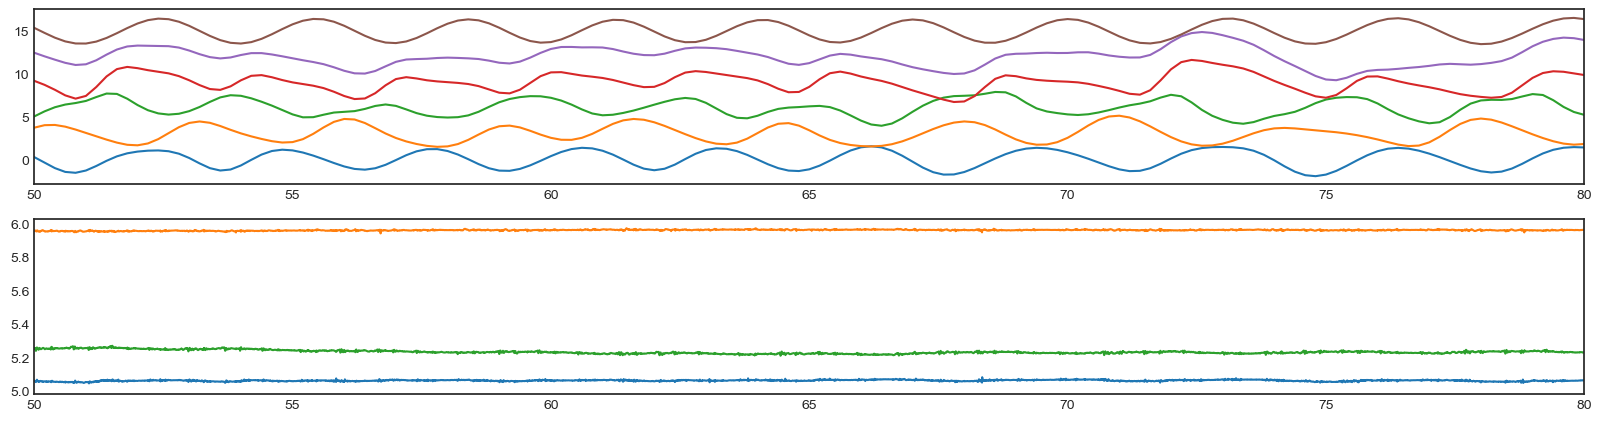

In [83]:

subject_id = '111'
task = 'Baseline'

fig, axes = plt.subplots(2,1,figsize=(20,5), dpi=100)
ax = axes[0]
df = df_resp_subs[(df_resp_subs['subject_id']==subject_id) & (df_resp_subs['task']==task)]

for i, DR_name in enumerate(['ECG_SR', 'SCGxyz_AMpt', 'accelZ_resp', 'ppg_ir_1_resp', 'ppg_g_1_resp', 'resp_cosmed']):
    ax.plot(df['time'].values-df['time'].values.min(), i*3+df[DR_name].values/df[DR_name].values.std())
ax.set_xlim(50,80)

ax = axes[1]
df = df_sync_extracted[(df_sync_extracted['subject_id']==subject_id) & (df_sync_extracted['task']==task)]
for j, sig_name in enumerate(['accelX', 'accelY', 'accelZ']):
    ax.plot(df['time'].values-df['time'].values.min(), i+df[sig_name].values)
ax.set_xlim(50,80)


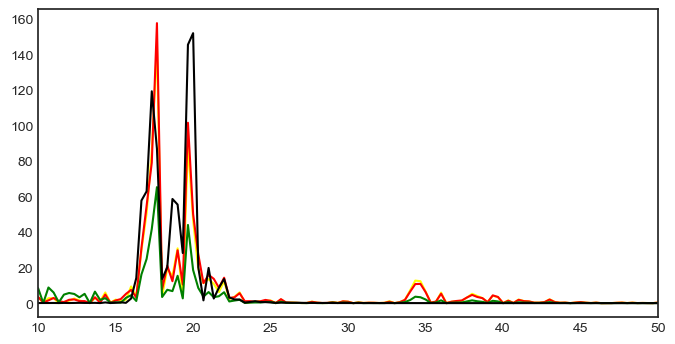

In [84]:
plt.figure(figsize=(8,4))
colors = ['yellow', 'red', 'green', 'black']

df = df_resp_subs[(df_resp_subs['subject_id']==subject_id) & (df_resp_subs['task']==task)]

# for i, ppg_name in enumerate(['ppg_ir_2_resp','ppg_r_2_resp', 'ppg_g_2_resp']):
for i, ppg_name in enumerate(['ppg_ir_1_resp','ppg_r_1_resp', 'ppg_g_1_resp', 'resp_cosmed']):
    xf, yf = get_psd(df[ppg_name].values/df[ppg_name].values.std(), Fs=FS_RESAMPLE_resp)
    # sys.exit()
    mask = (xf*60 >= 10) & (xf*60 <= 50)
    xf = xf[mask]*60
    yf = yf[mask]
    
    # if ppg_name=='ppg_ir_1_resp':
    #     yf = yf*10
    # if ppg_name=='ppg_g_1_resp':
    #     yf = yf*8
    # if ppg_name=='resp_cosmed':
    #     yf = yf*0.000000005
    
    if ppg_name=='resp_cosmed':
        plt.plot(xf, yf, color = colors[i])
    else:
        plt.plot(xf, yf, color = colors[i])
    
    plt.xlim(xf.min(),xf.max())

In [85]:
def get_ratio_ppgs(ppg1, ppg2, Fs):
    
    xf, yf1 = get_psd(ppg1, Fs=Fs)
    mask = (xf*60 >= 10) & (xf*60 <= 50)
    xf = xf[mask]*60
    yf1 = yf1[mask]

    xf, yf2 = get_psd(ppg2, Fs=Fs)
    mask = (xf*60 >= 10) & (xf*60 <= 50)
    xf = xf[mask]*60
    yf2 = yf2[mask]

    regr = LinearRegression(fit_intercept=True)
    regr.fit(yf1[:,None],yf2[:,None])
    ratio = regr.coef_[0][0]

    yf2_predict = regr.predict(yf2[:,None])
    norm2 = LA.norm(yf1[:,None]-yf2_predict, 2)        
    
    return ratio, norm2

In [86]:
ppg1 = df_resp['ppg_r_1_resp'].values
ppg2 = df_resp['ppg_ir_1_resp'].values
ratio_r2ir, norm2 = get_ratio_ppgs(ppg1, ppg2, FS_RESAMPLE_resp)
print(ratio_r2ir, norm2)

0.5935338850730838 0.032961154744569836


In [87]:
ppg1 = df_resp['ppg_g_1_resp'].values
ppg2 = df_resp['ppg_ir_1_resp'].values
ratio_g2ir, norm2 = get_ratio_ppgs(ppg1, ppg2, FS_RESAMPLE_resp)
print(ratio_g2ir, norm2)

0.1844510778175297 0.1553458611423533


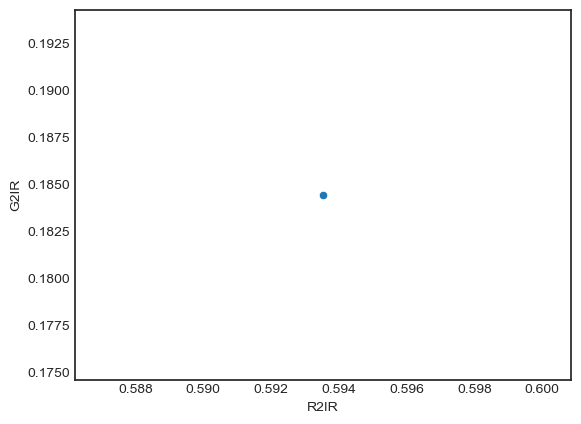

In [88]:
df_ppg_ratios = {
    'R2IR': ratio_r2ir,
    # 'IR': 1,
    'G2IR': ratio_g2ir,
}

df_ppg_ratios = pd.DataFrame(df_ppg_ratios, index=[0])

sns.scatterplot(data=df_ppg_ratios, x='R2IR', y='G2IR')

In [89]:
# FS_RESAMPLE_resp

In [90]:
def get_ratio_r2ir(r_beat, ir_beat):
#     this function compute the ratio of signal X to signal Y by solving the linear regression 
#     that describes the relationship between the two

#     y = a*x + b
#     r_beat[:,m] = a * ir_beat[:,m] + b
#     where a and b are scalar, and r_beat and ir_beat are matrices (dim=NxM)

    M = r_beat.shape[1]
    ratios_r2ir = np.zeros(M)
    norm2_r2ir = np.zeros(M)

    for m in range(M):
        regr = LinearRegression(fit_intercept=True)
        regr.fit(ir_beat[:,m][:,None],r_beat[:,m][:,None])
        ratios_r2ir[m] = regr.coef_[0][0]

        ir_predict = regr.predict(ir_beat[:,m][:,None])
        norm2_r2ir[m] = LA.norm(r_beat[:,m][:,None]-ir_predict, 2)        
    
    return ratios_r2ir, norm2_r2ir

In [91]:
# plt.plot(xf, yf1)
# plt.plot(xf, yf2)


In [92]:
# get

In [93]:
# get_ppg_ratiosq

In [94]:
# df_resp['time'].values


In [95]:
# xf.shape, FS_RESAMPLE_resp

In [96]:
# plt.plot(df_resp['RR_cosmed'])

In [97]:
# df_task['time'].values

In [98]:


# # xf, yf = get_psd(df['ppg_ir_1_cardiac'].values, Fs)

# xf, yf = get_psd(df['ppg_r_2_cardiac'].values, Fs)

In [99]:
# mask = (xf >= label_range_dict['HR'][0]/60) & (xf <= label_range_dict['HR'][1]/60)
# xf, yf = xf[mask], yf[mask]

In [100]:
# plt.plot(xf*60, yf )

In [101]:
# # plt.plot(df['HR_cosmed'].values)
# plt.plot(df['HR_patch'].values)
# # plt.plot(df['ppg_g_2_cardiac'].values)

In [102]:
# df_sync_extracted['subject_id'].unique()

In [103]:
# for subject_id in df_sync['subject_id'].unique():

        
    

#     if subject_id!='105':
#         continue

#     df_sub = df_sync[df_sync['subject_id']==subject_id]
#     outputdir_sub = outputdir+subject_id+'/'
    
#     for task_name in df_sub['task'].unique():
        


#         print('sub: {}, task: {}'.format(subject_id, task_name))
    
#         # 1. get QRS from ECG
#         df_task = df_sub[df_sub['task']==task_name].copy()
#         df_task = df_task.reset_index(drop=True)
        


        
        
#         # 3. detect features in ECG
#         ECG_raw_patch = df_task['ECG'].values
#         fig_name = 'ECG_diagnostics_'+task_name
#         QRS_detector_dict_patch = task_HR_detector(ECG_raw_patch, Fs, fig_name=fig_name, outputdir=outputdir_sub, show_plot=False)

#         # 4. get simulated resp. signal
#         resp_cosmed, br_sim_sig = get_RRVT2resp(df_task, Fs)

       
#         # 5. extract HR
#         t_sig = np.arange(ECG_raw_patch.shape[0])/Fs
#         hr_interp = np.interp(t_sig, QRS_detector_dict_patch['ts_hr'], QRS_detector_dict_patch['hr'])
#         # remove respiratory modulation on HR (is this necesary?)
#         hr_interp = get_padded_filt_DSwrapper(hr_interp, filter_padded=5, lowcutoff=None, highcutoff=0.05, Fs=Fs)

        

#         if task_name!='Recovery Walk':
#             continue
        
        
#         sys.exit()
        
        
#         for sig_name in df_task.keys():
#             if 'ppg' not in sig_name:
#                 continue


#         #     print(sig_name)

#             ppg = -get_padded_filt(df_task[sig_name].values, filter_padded=1, lowcutoff=FILT_PPG[0], highcutoff=FILT_PPG[1], Fs=Fs)
#             hr_ppg = get_PPG_HR(ppg, Fs)
            
#             print('sub:{}, task: {}, sig_name:{}| ecg hr: {:.2f} | ppg hr: {:.2f}'.format(subject_id, task_name,sig_name, hr_interp.mean(), hr_ppg))


In [104]:
# 

In [105]:
# print(task_name)

In [106]:
def plot_cardiac_diagnostic(df_task, Fs, fig_name=None, outputdir=None, show_plot=False):

    # sig_name = 'ppg_g_2'

    fig, axes = plt.subplots(8,1, figsize=(20,7), squeeze=False)
    t_sig = np.arange(df_task.shape[0])/Fs

    t_start = 10
    t_end = t_start + 50

    for i_sig, sig_name in enumerate(['ppg_g_1', 'ppg_r_1', 'ppg_ir_1', 'ppg_g_2', 'ppg_r_2', 'ppg_ir_2']):
    #     if 'ppg' not in sig_name:
    #         continue

        axes[i_sig,0].plot(t_sig, -get_padded_filt(df_task[sig_name].values, filter_padded=1,  lowcutoff=FILT_PPG[0], highcutoff=FILT_PPG[1], Fs=Fs))
    #     axes[i_sig,0].plot(t_sig, df_task[sig_name].values)
        axes[i_sig,0].set_xlim(t_start, t_end)

        axes[i_sig,0].set_ylabel(sig_name)

    axes[-2,0].plot(t_sig, get_padded_filt(df_task['ECG'].values, filter_padded=1, lowcutoff=FILT_ECG[0], highcutoff=FILT_ECG[1], Fs=Fs))
    axes[-2,0].set_xlim(t_start, t_end)

    axes[-1,0].plot(t_sig, get_padded_filt(df_task['accelZ'].values, filter_padded=1, lowcutoff=FILT_SCG[0], highcutoff=FILT_SCG[1], Fs=Fs))
    axes[-1,0].set_xlim(t_start, t_end)
    axes[-1,0].set_xlabel('time (s)')

    
    fig.tight_layout()

    if outputdir is not None:
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)
        if fig_name is None:
            fig_name = 'cardiac_diag'
        else:
            fig_name = fig_name

        fig.savefig(outputdir + fig_name,bbox_inches='tight', transparent=False)

    if show_plot == False:
        plt.close(fig)
        pyplot.close(fig)
        plt.close('all')
        
    plt.show()



    


In [107]:
# %%capture test

check_PPG_HR = False

if check_PPG_HR:
    
    df_ppg_hr = pd.DataFrame()
    
    for subject_id in df_sync['subject_id'].unique():


#         if subject_id!='106':
#             continue

        df_sub = df_sync[df_sync['subject_id']==subject_id]
        outputdir_sub = outputdir+subject_id+'/'

        for task_name in df_sub['task'].unique():


#             if task_name!='6MWT':
#                 continue

            print('sub: {}, task: {}'.format(subject_id, task_name))

            # 1. get QRS from ECG
            df_task = df_sub[df_sub['task']==task_name].copy()
            df_task = df_task.reset_index(drop=True)

            # 3. detect features in ECG
            ECG_raw_patch = df_task['ECG'].values
            fig_name = 'ECG_diagnostics_'+task_name
            QRS_detector_dict_patch = task_HR_detector(ECG_raw_patch, Fs, fig_name=fig_name, outputdir=outputdir_sub, show_plot=False)

            # 4. get simulated resp. signal
            resp_cosmed, br_sim_sig = get_RRVT2resp(df_task, Fs)


            # 5. extract HR
            t_sig = np.arange(ECG_raw_patch.shape[0])/Fs
            hr_interp = np.interp(t_sig, QRS_detector_dict_patch['ts_hr'], QRS_detector_dict_patch['hr'])
            # remove respiratory modulation on HR (is this necesary?)
            hr_interp = get_padded_filt_DSwrapper(hr_interp, filter_padded=5, lowcutoff=None, highcutoff=0.05, Fs=Fs)


            plot_cardiac_diagnostic(df_task, Fs, fig_name='{}_{}'.format(subject_id, task_name), outputdir=outputdir_cardiac, show_plot=False)


#             if task_name=='Recovery Run':
#                 continue


    #         sys.exit()


            for sig_name in df_task.keys():
                if 'ppg' not in sig_name:
                    continue


                hr_freq = hr_interp.mean()/60 # Hz
            #     print(sig_name)

                ppg = -get_padded_filt(df_task[sig_name].values, filter_padded=1, lowcutoff=hr_freq-0.3, highcutoff=hr_freq+0.3, Fs=Fs)
                hr_ppg = get_PPG_HR(ppg, Fs)

#                 print('sub:{}, task: {}, sig_name:{}| ecg hr: {:.2f} | ppg hr: {:.2f}'.format(subject_id, task_name,sig_name, hr_interp.mean(), hr_ppg))

                
                ppg_hr_dict = {
                    'subject_id': subject_id,
                    'task_name': task_name,
                    'sig_name': sig_name,
                    'hr_ecg': hr_interp.mean(),
                    'hr_ppg': hr_ppg,
                }
                
                df_ppg_hr = df_ppg_hr.append(ppg_hr_dict, ignore_index=True)
                
                
    df_ppg_hr['hr_mae'] = np.abs(df_ppg_hr['hr_ecg'] - df_ppg_hr['hr_ppg'])
    df_ppg_hr.to_feather(outputdir_cardiac+'df_ppg_hr.feather')
#     df_ppg_hr = pd.read_feather(outputdir_cardiac+'df_ppg_hr.feather')

    print('ppg_hr checker done!')
    

    for task_name in df_ppg_hr['task_name'].unique():
        df = df_ppg_hr[df_ppg_hr['task_name']==task_name]

        fig, ax = plt.subplots(figsize=(10,3))
        sns.barplot(data=df, x="subject_id", y="hr_mae", hue="sig_name", ax=ax)
        ax.set_title(task_name)
        ax.legend(loc='upper right')
        plt.show()

In [108]:
list_sungtae_columns = ['subject_id', 'task', 'weight', 'height', 'gender', 'age', 'time', 'HR_cosmed','RR_cosmed', 'VO2_cosmed', 'GpsAlt_cosmed', 'Sampled_cosmed', 'ECG', 'accelX', 'accelY', 'accelZ', 'HR_patch', 'pres']

In [109]:
ECG_patch_noisy = {
    '101': [],
    '102': [],
    '103': ['Run'],
    '104': [],
    '105': ['Run'],
    '106': [],
    '107': [],
    # 108 may be fixable
    '108': ['6MWT-R', 'Recovery StairDown1', 'StairDown1', 'Walk', 'StairDown0', 'Run', 'Recovery Walk', 'Recovery Run', '6MWT'],
    '109': ['Baseline', '6MWT', '6MWT-R', 'StairDown0', 'StairUp0', 'StairDown1', 'Walk', 'Run', 'Recovery 6MWT','Recovery 6MWT-R', 'Recovery StairDown1', 'Recovery Walk', 'Recovery Run'],
    '110': ['Run'],
    '111': ['Run'],
    '113': [],
    '114': ['Run'],
    '115': [],
    '116': ['6MWT', 'StairDown0', 'StairDown1', 'Run'],
    '117': ['6MWT-R', '6MWT', 'Walk', 'StairUp0', 'StairDown0', 'StairDown1', 'Walk', 'Run'],
    '118': ['Run'],
    # 119 is fixable
    '119': ['6MWT', 'Recovery 6MWT-R', '6MWT-R', 'Recovery Run', 'StairDown1', 'Walk', 'StairUp0', 'StairDown0', 'Run', 'Recovery 6MWT'],
    '120': ['Run'],
    '121': ['Run'],
    '212': ['6MWT', 'StairDown0', 'StairUp0', 'Walk', 'StairDown1', 'Run', 'Recovery Run', 'Recovery 6MWT-R'],
}

In [110]:
# df_sub = df_sync_extracted[df_sync_extracted['subject_id']=='119']
# df_task = df_sub[ (df_sub['task']=='StairDown1')]
# df_task

In [111]:
show_bad_ecg=False
if show_bad_ecg:
    for subject_id in ECG_patch_noisy.keys():
        print(subject_id)
        sub_dict = ECG_patch_noisy[subject_id]
        if len(sub_dict)!=0:
            df_sub = df_sync_extracted[df_sync_extracted['subject_id']==subject_id]

            for task_name in sub_dict:
                df_task = df_sub[ (df_sub['task']==task_name)]
                plt.figure(figsize=(60,2))
                plt.plot(df_task['ECG_filt'].values)
                plt.title('{} {}'.format(subject_id, task_name))

In [112]:
# data_saver(ECG_patch_noisy, 'ECG_patch_noisy', outputdir)

In [113]:
# data_loader('ECG_patch_noisy', outputdir)

In [114]:
task_names_all = df_sync_extracted['task'].unique()

In [115]:
task_names_all

array(['Baseline', 'Recovery 6MWT', 'Recovery 6MWT-R',
       'Recovery StairDown1', 'Recovery Walk', 'Recovery Run', '6MWT',
       '6MWT-R', 'StairDown0', 'StairUp0', 'StairDown1', 'Walk', 'Run'],
      dtype=object)

In [116]:

# weight, height, gender, age

In [117]:

check_store_extracted = True

if check_store_extracted:
    
    for subject_id in df_sync_extracted['subject_id'].unique():

        df_sub = df_sync_extracted[df_sync_extracted['subject_id']==subject_id].copy()
        weight = df_subinfo[df_subinfo['Subject_ID']==subject_id]['Weight'].values[0]
        height = df_subinfo[df_subinfo['Subject_ID']==subject_id]['Height'].values[0]
        gender = df_subinfo[df_subinfo['Subject_ID']==subject_id]['Gender'].values[0]
        age = df_subinfo[df_subinfo['Subject_ID']==subject_id]['Age'].values[0]

        df_sub['weight'] = weight
        df_sub['height'] = height
        df_sub['gender'] = gender
        df_sub['age'] = age
#         sys.exit()
        for task_name in df_sub['task'].unique():
            
            outputdir_task = outputdir+subject_id+'/'+task_name+'/'
            if not os.path.exists(outputdir_task):
                os.makedirs(outputdir_task)
    
            df_task = df_sub[(df_sub['task']==task_name)]
            df_task = df_task.reset_index(drop=True)
            df_task = df_task[list_sungtae_columns]
            print('Store data for sub: {}, task: {}'.format(subject_id, task_name))

            df_task[list_sungtae_columns].to_feather(outputdir_task+'df_sync_extracted_{}.feather'.format(subject_id))

            # 1. get QRS from ECG
#             df_task = df_sub[df_sub['task']==task_name].copy()
#             df_task = df_task.reset_index(drop=True)

Store data for sub: 101, task: Baseline
Store data for sub: 101, task: Recovery 6MWT
Store data for sub: 101, task: Recovery 6MWT-R
Store data for sub: 101, task: Recovery StairDown1
Store data for sub: 101, task: Recovery Walk
Store data for sub: 101, task: Recovery Run
Store data for sub: 101, task: 6MWT
Store data for sub: 101, task: 6MWT-R
Store data for sub: 101, task: StairDown0
Store data for sub: 101, task: StairUp0
Store data for sub: 101, task: StairDown1
Store data for sub: 101, task: Walk
Store data for sub: 101, task: Run
Store data for sub: 102, task: Baseline
Store data for sub: 102, task: Recovery 6MWT
Store data for sub: 102, task: Recovery 6MWT-R
Store data for sub: 102, task: Recovery StairDown1
Store data for sub: 102, task: Recovery Walk
Store data for sub: 102, task: Recovery Run
Store data for sub: 102, task: 6MWT
Store data for sub: 102, task: 6MWT-R
Store data for sub: 102, task: StairDown0
Store data for sub: 102, task: StairUp0
Store data for sub: 102, task: 

In [118]:
# df_sub['task'].unique()

In [119]:
# subject_id=101
df_ppg_selected = pd.DataFrame()
ppg_selector = 'RQI_method'

if ppg_selector=='hr_method':
    print('choose', ppg_selector)
    df_ppg_hr['hr_mae'] = np.abs(df_ppg_hr['hr_ecg'] - df_ppg_hr['hr_ppg'])

    for subject_id in df_ppg_hr['subject_id'].unique():
        for task_name in df_ppg_hr['task_name'].unique():
            df = df_ppg_hr[(df_ppg_hr['subject_id']==subject_id) & (df_ppg_hr['task_name']==task_name)]

            MIN_hr_mae = df['hr_mae'].min()
            ppg_selected = None
            for ppg_name in ['ppg_g_2', 'ppg_g_1', 'ppg_ir_2', 'ppg_ir_1', 'ppg_r_2', 'ppg_r_1']:

                if MIN_hr_mae == df[df['sig_name']==ppg_name]['hr_mae'].values[0]:
                    ppg_selected = ppg_name
                    break

            selected_dict = {
                'subject_id': subject_id,
                'task_name': task_name,
                'ppg_selected': ppg_selected,
            }

            df_ppg_selected = df_ppg_selected.append(selected_dict, ignore_index=True)


    #     df_ppg_selected = pd.read_feather(outputdir_cardiac+'df_ppg_selected.feather')

elif ppg_selector=='RQI_method':
    print('choose', ppg_selector)
    list_ppg_names = ['ppg_ir_1_resp','ppg_ir_2_resp','ppg_g_1_resp','ppg_g_2_resp']

    for subject_id in df_resp_subs['subject_id'].unique():
        for task_name in df_resp_subs['task'].unique():
            df_resp = df_resp_subs[(df_resp_subs['subject_id']==subject_id) & (df_resp_subs['task']==task_name)]

            sig_matrix = df_resp[list_ppg_names].values

            xf, yf_matrix = get_psd(sig_matrix.T, FS_RESAMPLE_resp) # xf is in Hz
            
#             xf, yf = get_psd(df_resp[resp_name].values, FS_RESAMPLE_resp) #xf is in Hz
            mask = (xf*60 >= 5) & (xf*60 <= 60) # RR can only be between 0-60 breaths per minute 
            xf = xf[mask]
            yf_matrix = yf_matrix[:, mask]

#             fig, ax = plt.subplots()
#             ax.plot(xf[mask]*60, yf[mask])
            
            RQI_ppgs = get_RQI_fft(yf_matrix)
            ppg_selected = list_ppg_names[np.argmax(RQI_ppgs)]

            selected_dict = {
                'subject_id': subject_id,
                'task_name': task_name,
                'ppg_selected': ppg_selected,
            }
            
#             if (subject_id=='120') & (task_name=='6MWT'):
#                 sys.exit()

            df_ppg_selected = df_ppg_selected.append(selected_dict, ignore_index=True)

df_ppg_selected.to_feather(outputdir_cardiac+'df_ppg_selected.feather')

print('selected best ppg for each subject, each task!')


choose RQI_method
selected best ppg for each subject, each task!


# selected PPG based on HR_mae compared to ECG (for RR estimation paper)

In [120]:
# xf, yf_matrix = get_psd(sig_matrix.T, FS_RESAMPLE_resp) # xf is in Hz
# yf_matrix.shape

In [121]:

del df_sync
del df_task
del df_sub

# show RR estimated, store these resp signals

In [122]:
if training_params['extract_resp']:
    df_resp_subs.to_feather(outputdir_resp+'df_resp_subs.feather')


In [123]:
del df_resp_subs

In [124]:
df_sync_extracted.keys()

Index(['HR_cosmed', 'RR_cosmed', 'VT_cosmed', 'VE_cosmed', 'FeO2_cosmed',
       'FeCO2_cosmed', 'FiO2_cosmed', 'FiCO2_cosmed', 'VO2_cosmed',
       'VCO2_cosmed', 'EE_cosmed', 'SPO2_cosmed', 'GpsAlt_cosmed',
       'AmbTemp_cosmed', 'Battery_cosmed', 'K5_R_cosmed', 'time',
       'Marker_cosmed', 'task', 'Sampled_cosmed', 'ECG', 'accelX', 'accelY',
       'accelZ', 'ppg_g_1', 'ppg_r_1', 'ppg_ir_1', 'ppg_g_2', 'ppg_r_2',
       'ppg_ir_2', 'temp_skin', 'pres', 'OUES_cosmed', 'subject_id',
       'Rnormed_cosmed', 'RQ_calories', 'EErq_cosmed', 'ECG_filt',
       'accelX_filt', 'accelY_filt', 'accelZ_filt', 'scgX', 'scgY', 'scgZ',
       'ppg_g_1_cardiac', 'ppg_g_2_cardiac', 'ppg_r_1_cardiac',
       'ppg_r_2_cardiac', 'ppg_ir_1_cardiac', 'ppg_ir_2_cardiac',
       'ppg_g_1_resp', 'ppg_g_2_resp', 'ppg_r_1_resp', 'ppg_r_2_resp',
       'ppg_ir_1_resp', 'ppg_ir_2_resp', 'HR_patch', 'resp_cosmed',
       'br_sim_sig', 'O2pulse_cosmedpatch', 'scgXYZ', 'scgX_0.00Hz',
       'scgX_3.91Hz', 'sc

# normalize HR_patch 
## TODO: move to the first fat cell

In [125]:
for subject_id in df_sync_extracted['subject_id'].unique():
    
    print('working on', subject_id)

    df_sub = df_sync_extracted[df_sync_extracted['subject_id']==subject_id]
    
    task_name = 'Baseline'
    df_task = df_sub[df_sub['task']==task_name].reset_index(drop=True).copy()
    
    # 2. normalize HR based on Altini's method (physio - baseline mean) / (physio high at high intensity act. - baseline mean)
    
    HR_baseline = df_task['HR_patch'].mean()
    HR_range = df_sub['HR_patch'].max() - df_sub['HR_patch'].min()

    df_sync_extracted.loc[df_sync_extracted['subject_id']==subject_id, 'HR_patchnormed'] = (df_sub['HR_patch'] - HR_baseline ) / HR_range   
    

working on 101
working on 102
working on 103
working on 104
working on 105
working on 106
working on 107
working on 108
working on 109
working on 110
working on 111
working on 113
working on 114
working on 115
working on 116
working on 117
working on 118
working on 119
working on 120
working on 121
working on 212


In [126]:
# print('correcting time...')
# for subject_id in df_sync_extracted['subject_id'].unique():
    
#     print('working on', subject_id)

#     df_sub = df_sync_extracted[df_sync_extracted['subject_id']==subject_id]

#     for task_name in df_sub['task'].unique():
#         df_task = df_sub[df_sub['task']==task_name].reset_index(drop=True).copy()

# add demographic

In [127]:
for subject_id in df_sync_extracted['subject_id'].unique():
    
    print('working on', subject_id)

    # 1. get subject's demographic from df_subinfo
    weight = df_subinfo[df_subinfo['Subject_ID']==subject_id]['Weight'].values[0]
    height = df_subinfo[df_subinfo['Subject_ID']==subject_id]['Height'].values[0]
    gender = df_subinfo[df_subinfo['Subject_ID']==subject_id]['Gender_encoded'].values[0]
    age = df_subinfo[df_subinfo['Subject_ID']==subject_id]['Age'].values[0]
    BMR =  df_subinfo[df_subinfo['Subject_ID']==subject_id]['BMR'].values[0]
    BMI = weight / (height/100)**2
    
    # 2. assign the demographic data to the subjects to df_sync_extracted
#     df_sub = df_sync_extracted[df_sync_extracted['subject_id']==subject_id]
    mask_sub = df_sync_extracted['subject_id']==subject_id
    df_sync_extracted.loc[mask_sub, 'weight'] = weight
    df_sync_extracted.loc[mask_sub, 'height'] = height
    df_sync_extracted.loc[mask_sub, 'gender'] = gender
    df_sync_extracted.loc[mask_sub, 'age'] = age
    df_sync_extracted.loc[mask_sub, 'BMR'] = BMR
    df_sync_extracted.loc[mask_sub, 'BMI'] = BMI
    
    # 3. get the weighted estimated data from df_label_baseline
    mask = df_label_baseline['subject_id']==int(subject_id)    
    EErq_est_val = df_label_baseline[mask]['EErq_est_val'].values[0]
    VT_est_val = df_label_baseline[mask]['VT_est_val'].values[0]
    VO2_est_val = df_label_baseline[mask]['VO2_est_val'].values[0]
    
    # 4. assign weighted estimated data to df_sync_extracted
    df_sync_extracted.loc[mask_sub, 'EErq_est'] = EErq_est_val
    df_sync_extracted.loc[mask_sub, 'VT_est'] = VT_est_val
    df_sync_extracted.loc[mask_sub, 'VO2_est'] = VO2_est_val

    df_sync_extracted.loc[mask_sub, 'EErq_cosmedweighted'] = df_sync_extracted.loc[mask_sub, 'EErq_cosmed'] / weight
    df_sync_extracted.loc[mask_sub, 'VO2_cosmedweighted'] = df_sync_extracted.loc[mask_sub, 'VO2_cosmed'] / weight


working on 101
working on 102
working on 103
working on 104
working on 105
working on 106
working on 107
working on 108
working on 109
working on 110
working on 111
working on 113
working on 114
working on 115
working on 116
working on 117
working on 118
working on 119
working on 120
working on 121
working on 212


In [128]:
# df_sync

In [129]:
for subject_id in df_sync_extracted['subject_id'].unique():
    
    print('working on', subject_id)
    mask_sub = df_sync_extracted['subject_id']==subject_id
    df_sub = df_sync_extracted[mask_sub]

    # 1. get baseline dataframe
    df_baseline = df_sub[df_sub['task']=='Baseline']
    
#     VT_baseline = df_baseline['VT_cosmed'].mean()
#     EErq_baseline = df_baseline['EErq_cosmed'].mean()
    

    # weight = df_sub['weight'].values[0]
    # EErq_baseline = df_sub['EErq_est'].values[0]
    # VO2_baseline = df_sub['VO2_est'].values[0]
    # VT_baseline = df_sub['VTavg_est'].values[0]

    # 2. get baseline value for each subject, each ground truth
    EErq_baseline = df_sub['EErq_cosmed'].mean()
    VO2_baseline = df_sub['VO2_cosmed'].mean()
    VT_baseline = df_sub['VT_cosmed'].mean()
    
    EErq_weighted_baseline = df_sub['EErq_cosmedweighted'].mean()
    VO2_weighted_baseline = df_sub['VO2_cosmedweighted'].mean()

    # 2. get baseline value for each subject, each ground truth    
    # mask_task = (df_sync_extracted['subject_id']==subject_id) & (df_sync_extracted['task']==task_name)
    df_sync_extracted.loc[mask_sub, 'EErq_cosmeddelta'] = df_sync_extracted.loc[mask_sub, 'EErq_cosmed'] - EErq_baseline
    df_sync_extracted.loc[mask_sub, 'VT_cosmeddelta'] = df_sync_extracted.loc[mask_sub, 'VT_cosmed'] - VT_baseline
    df_sync_extracted.loc[mask_sub, 'VO2_cosmeddelta'] = df_sync_extracted.loc[mask_sub, 'VO2_cosmed'] - VO2_baseline

    df_sync_extracted.loc[mask_sub, 'EErq_weighted_cosmeddelta'] = df_sync_extracted.loc[mask_sub, 'EErq_cosmedweighted'] - EErq_weighted_baseline
    df_sync_extracted.loc[mask_sub, 'VO2_weighted_cosmeddelta'] = df_sync_extracted.loc[mask_sub, 'VO2_cosmedweighted'] - VO2_weighted_baseline

#     for task_name in df_sub['task'].unique():
#         mask_task = (df_sync_extracted['subject_id']==subject_id) & (df_sync_extracted['task']==task_name)
#         # df_sync_extracted.loc[mask_task, 'VT_cosmedperc'] = df_sync_extracted.loc[mask_task, 'VT_cosmed'] / VT_baseline
#         # df_sync_extracted.loc[mask_task, 'EErq_cosmedperc'] = df_sync_extracted.loc[mask_task, 'EErq_cosmed'] / EErq_baseline
#         # df_sync_extracted.loc[mask_task, 'scg_std_perc'] = df_sync_extracted.loc[mask_task, 'scg_std'] / scg_std_baseline
#         df_sync_extracted.loc[mask_task, 'EErq_cosmeddelta'] = df_sync_extracted.loc[mask_task, 'EErq_cosmed'] - EErq_baseline
#         df_sync_extracted.loc[mask_task, 'VT_cosmeddelta'] = df_sync_extracted.loc[mask_task, 'VT_cosmed'] - VT_baseline
#         df_sync_extracted.loc[mask_task, 'VO2_cosmeddelta'] = df_sync_extracted.loc[mask_task, 'VO2_cosmed'] - VO2_baseline

#         df_sync_extracted.loc[mask_task, 'EErq_cosmedweighted'] = df_sync_extracted.loc[mask_task, 'EErq_cosmedweighted'] - EErq_weighted_baseline
#         df_sync_extracted.loc[mask_task, 'VO2_cosmedweighted'] = df_sync_extracted.loc[mask_task, 'VO2_cosmedweighted'] - VO2_weighted_baseline


working on 101
working on 102
working on 103
working on 104
working on 105
working on 106
working on 107
working on 108
working on 109
working on 110
working on 111
working on 113
working on 114
working on 115
working on 116
working on 117
working on 118
working on 119
working on 120
working on 121
working on 212


In [130]:
# plt.plot(df_sync_extracted['EErq_cosmedperc'].values)
# plt.plot(df_sync_extracted['scg_std_perc'].values)

# plt.plot(df_sync_extracted['subject_id'].values)


In [131]:
# df_sync_extracted

# show O2 pulse

In [132]:
show_O2pulse = False

if show_O2pulse:
    for subject_id in df_sync_extracted['subject_id'].unique():
        df_sub = df_sync_extracted[df_sync_extracted['subject_id']==subject_id]

        fig, (ax1, ax2) = plt.subplots(2,1,figsize=(5,5), dpi=100)
        ts= np.arange(df_sub.shape[0])/Fs
        ax1.plot(ts, df_sub['O2pulse_cosmedpatch'])
        ax1.set_ylabel('O2pulse_cosmedpatch\n[ml/beat]')
        ax1.set_title(subject_id)
        ax2.plot(ts, df_sub['task'])
        ax2.set_xlabel('time (s)')

# TBD: filter signals in each activity

In [133]:
# df_filterd = []

# for subject_id in df_sync_extracted['subject_id'].unique():
#     df_sub = df_sync_extracted[df_sync_extracted['subject_id']==subject_id]
    
#     for task_name in df_sub['task'].unique():
        
#         df_task = df_sub[df_sub['task']==task_name]
#         df_task = filter_DFcolumns(df_task.copy(), Fs)
        
#         df_filterd.append(df_task)
        
# df_filterd = pd.concat(df_filterd).reset_index(drop=True)

# show correlation between VE and EE

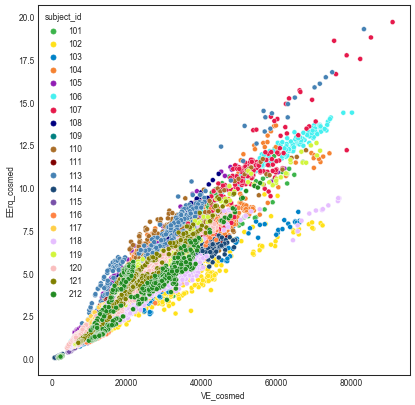

In [134]:
fig, ax = plt.subplots(1,1, figsize=(8,8), dpi=60)
# sns.scatterplot(data=df_sync_extracted[df_sync_extracted['Sampled_cosmed']==1], x="HR_patchnormed", y="EErq_cosmed", hue="subject_id", ax=ax)
# sns.scatterplot(data=df_sync_extracted[(df_sync_extracted['Sampled_cosmed']==1) & (df_sync_extracted['task']!='Recovery Run')], x="VE_cosmed", y="EErq_cosmed", hue="subject_id", ax=ax, palette=subject_str_palette)
sns.scatterplot(data=df_sync_extracted[(df_sync_extracted['Sampled_cosmed']==1) & (df_sync_extracted['K5_R_cosmed']<=1)], x="VE_cosmed", y="EErq_cosmed", hue="subject_id", ax=ax, palette=subject_str_palette)

In [135]:
# df_sync_extracted

In [136]:
# fig, ax = plt.subplots(1,1, figsize=(8,8), dpi=80)
# # sns.scatterplot(data=df_sync_extracted[df_sync_extracted['Sampled_cosmed']==1], x="HR_patchnormed", y="EErq_cosmed", hue="subject_id", ax=ax)
# sns.scatterplot(data=df_sync_extracted[df_sync_extracted['Sampled_cosmed']==1], x="ppg_r_2_resp_respsur_env", y="VT_cosmed", hue="subject_id", ax=ax, palette=subject_str_palette)

In [137]:
# df_sync_extracted.columns

In [138]:
# df_sync_extracted['EErq_cosmednormed'] = df_sync_extracted['EErq_cosmed']/df_sync_extracted['weight']
# df_sync_extracted['VT_cosmednormed'] = df_sync_extracted['VT_cosmed']/df_sync_extracted['weight']


In [139]:
# df_sub

In [140]:
show_correlation = False

if show_correlation:
    
#     x_name = 'scg_std'
#     x_name = 'CO_patchsur'
    x_name = 'ppg_ir_2_resp_respsur_filtered_env'
#     x_name = 'ECG_SR_respsur_filtered_env'
#     ppg_r_1_resp_respsur_filtered_env
    y_name = 'VT_cosmed'
#     y_name = 'EErq_cosmed'

    for subject_id in df_sync_extracted['subject_id'].unique():
        fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=80)

        df_sub = df_sync_extracted[df_sync_extracted['subject_id']==subject_id]
        df_sub = df_sub[df_sub['Sampled_cosmed']==1]

        sns.scatterplot(data=df_sub, x=x_name, y=y_name, hue="task", ax=ax)
        ax.set_title(subject_id)

# feature correlation analysis

In [141]:
# list_features_PCC = ['CO_patchsur', 'HR_patch','HR_patchnormed','scg_std','scg_std_perc', 'VE_cosmed', 'VT_cosmed','RR_cosmed']
# list_output_PCC = ['EErq_cosmed', 'EErq_cosmedperc']
# df_tmp = df_sync_extracted[(df_sync_extracted['Sampled_cosmed']==1)]

# df_PCC = pd.DataFrame()

# for output_name in list_output_PCC:
#     for feature_name in list_features_PCC:
#         PCC = get_PCC(df_tmp[feature_name].values, df_tmp[output_name].values)

#         df_PCC = df_PCC.append(pd.DataFrame(
#             {
#                 'feature_name': [feature_name],
#                 'output_name': [output_name],
#                 'PCC': [PCC],
#             }
#         ))
        
# df_PCC['feature_name'] = pd.Categorical(df_PCC['feature_name'],ordered=True,categories=list_features_PCC)

# fig, ax = plt.subplots(1,1,dpi=150)

# pivot = df_PCC.pivot(index='feature_name', columns='output_name', values='PCC')

# sns.heatmap(pivot, annot=True, ax=ax,  linewidths=.5)
# plt.show()

In [142]:
# plt.plot( df_tmp['EErq_cosmed'].values)

In [143]:
# df_tmp['CO_patchsur'].values, df_tmp['EErq_cosmed'].values 

# plt.plot(df_tmp['scg_std'].values)
df_sync_extracted.keys()

Index(['HR_cosmed', 'RR_cosmed', 'VT_cosmed', 'VE_cosmed', 'FeO2_cosmed',
       'FeCO2_cosmed', 'FiO2_cosmed', 'FiCO2_cosmed', 'VO2_cosmed',
       'VCO2_cosmed',
       ...
       'EErq_est', 'VT_est', 'VO2_est', 'EErq_cosmedweighted',
       'VO2_cosmedweighted', 'EErq_cosmeddelta', 'VT_cosmeddelta',
       'VO2_cosmeddelta', 'EErq_weighted_cosmeddelta',
       'VO2_weighted_cosmeddelta'],
      dtype='object', length=114)

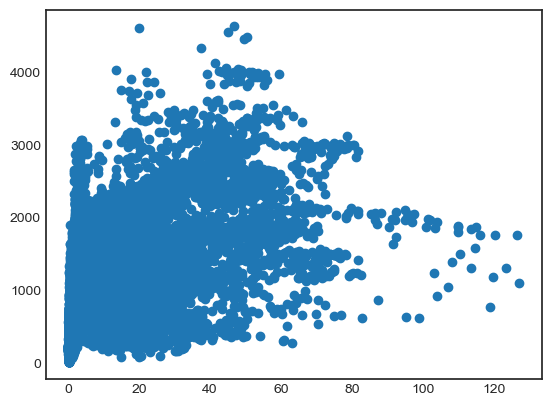

0.6021449976101269


In [144]:
def assess_feature(feature, output):
    plt.scatter(feature, output)
    plt.show()
    print(get_PCC(feature, output))
    
# df_tmp = df_sync_extracted[(df_sync_extracted['Sampled_cosmed']==1) & (df_sync_extracted['K5_R_cosmed']<=1)]

# label_name = 'EErq_cosmed'
label_name = 'VO2_cosmed'
feature_name = 'scgZ_CO'
# feature_name = 'scg_std'

df_tmp = df_sync_extracted[(df_sync_extracted['Sampled_cosmed']==1)][[feature_name, label_name]]
df_tmp = df_tmp.dropna()

assess_feature( df_tmp[feature_name].values, df_tmp[label_name].values )


In [145]:
# assess_feature

In [146]:
df_sync_extracted.keys()

Index(['HR_cosmed', 'RR_cosmed', 'VT_cosmed', 'VE_cosmed', 'FeO2_cosmed',
       'FeCO2_cosmed', 'FiO2_cosmed', 'FiCO2_cosmed', 'VO2_cosmed',
       'VCO2_cosmed',
       ...
       'EErq_est', 'VT_est', 'VO2_est', 'EErq_cosmedweighted',
       'VO2_cosmedweighted', 'EErq_cosmeddelta', 'VT_cosmeddelta',
       'VO2_cosmeddelta', 'EErq_weighted_cosmeddelta',
       'VO2_weighted_cosmeddelta'],
      dtype='object', length=114)

# scg_std vs. EErq_cosmed

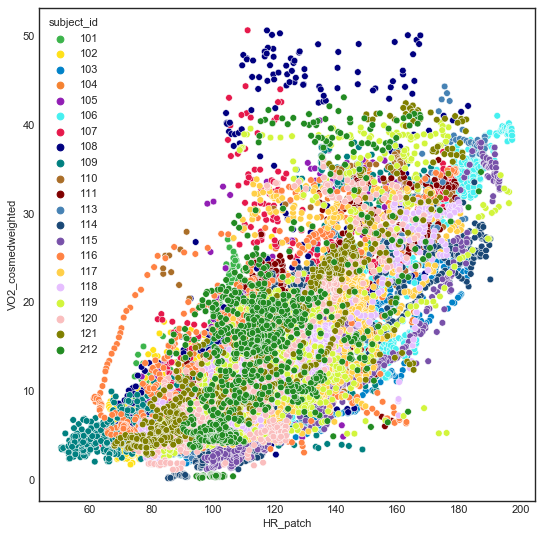

In [147]:
fig, ax = plt.subplots(1,1, figsize=(8,8), dpi=80)
sns.scatterplot(data=df_sync_extracted[(df_sync_extracted['Sampled_cosmed']==1) ], x="HR_patch", y="VO2_cosmedweighted", hue="subject_id", ax=ax, palette=subject_str_palette)
# sns.scatterplot(data=df_sync_extracted[(df_sync_extracted['Sampled_cosmed']==1) & (df_sync_extracted['task']!='6MWT') ], x="scg_std_perc", y="EErq_cosmed", hue="task", ax=ax)
# sns.scatterplot(data=df_sync_extracted[(df_sync_extracted['Sampled_cosmed']==1) ], x="CO_patchsur", y="EErq_cosmed", hue="subject_id", ax=ax, palette=subject_str_palette)
# sns.scatterplot(data=df_sync_extracted[(df_sync_extracted['Sampled_cosmed']==1) ], x="scg_std_perc", y="EErq_cosmedweighted", hue="subject_id", ax=ax)
# sns.scatterplot(data=df_sync_extracted[(df_sync_extracted['Sampled_cosmed']==1) & (df_sync_extracted['subject_id']=='103')], x="19.53Hz", y="VT_cosmed", hue="subject_id", ax=ax)

# VO2 vs. EE

In [148]:
# fig, ax = plt.subplots(1,1, figsize=(8,8), dpi=80)
# sns.scatterplot(data=df_sync_extracted[df_sync_extracted['Sampled_cosmed']==1], x="VO2_cosmed", y="EErq_cosmed", hue="subject_id", ax=ax)

In [149]:
# list_feature

In [8]:
# list_feature = ["HR_patch", "HR_patchnormed", "VE_cosmed", "scgX_std","scgX_CO", "scgY_std","scgY_CO", "scgZ_std","scgZ_CO", "scgXYZ_std","scgXYZ_CO", "weight", "EErq_est", "VT_est"]


# add spectral features

In [151]:
if include_spectral:
    list_spectral = []

    for key in df_sync_extracted.columns:
        if 'Hz'in key:
            
            # freq = float(key.split('Hz')[0])
            freq = float(key.split('Hz')[0].split('_')[1])
            if freq > FILT_SCG[1]:
                continue
            list_spectral.append(key)
            
            
    list_feature = list_feature + list_spectral

In [152]:
list_feature

['HR_patch',
 'HR_patchnormed',
 'VE_cosmed',
 'scgY_std',
 'scgY_CO',
 'scgZ_std',
 'scgZ_CO',
 'weight',
 'EErq_est',
 'VT_est',
 'scgX_0.00Hz',
 'scgX_3.91Hz',
 'scgX_7.81Hz',
 'scgX_11.72Hz',
 'scgX_15.62Hz',
 'scgX_19.53Hz',
 'scgX_23.44Hz',
 'scgY_0.00Hz',
 'scgY_3.91Hz',
 'scgY_7.81Hz',
 'scgY_11.72Hz',
 'scgY_15.62Hz',
 'scgY_19.53Hz',
 'scgY_23.44Hz',
 'scgZ_0.00Hz',
 'scgZ_3.91Hz',
 'scgZ_7.81Hz',
 'scgZ_11.72Hz',
 'scgZ_15.62Hz',
 'scgZ_19.53Hz',
 'scgZ_23.44Hz',
 'scgXYZ_0.00Hz',
 'scgXYZ_3.91Hz',
 'scgXYZ_7.81Hz',
 'scgXYZ_11.72Hz',
 'scgXYZ_15.62Hz',
 'scgXYZ_19.53Hz',
 'scgXYZ_23.44Hz']

In [153]:
list_feature = list_feature + ['weight', 'height', 'gender', 'age', 'BMR', 'BMI', 'EErq_est', 'VT_est', 'VO2_est']

In [154]:
list_feature

['HR_patch',
 'HR_patchnormed',
 'VE_cosmed',
 'scgY_std',
 'scgY_CO',
 'scgZ_std',
 'scgZ_CO',
 'weight',
 'EErq_est',
 'VT_est',
 'scgX_0.00Hz',
 'scgX_3.91Hz',
 'scgX_7.81Hz',
 'scgX_11.72Hz',
 'scgX_15.62Hz',
 'scgX_19.53Hz',
 'scgX_23.44Hz',
 'scgY_0.00Hz',
 'scgY_3.91Hz',
 'scgY_7.81Hz',
 'scgY_11.72Hz',
 'scgY_15.62Hz',
 'scgY_19.53Hz',
 'scgY_23.44Hz',
 'scgZ_0.00Hz',
 'scgZ_3.91Hz',
 'scgZ_7.81Hz',
 'scgZ_11.72Hz',
 'scgZ_15.62Hz',
 'scgZ_19.53Hz',
 'scgZ_23.44Hz',
 'scgXYZ_0.00Hz',
 'scgXYZ_3.91Hz',
 'scgXYZ_7.81Hz',
 'scgXYZ_11.72Hz',
 'scgXYZ_15.62Hz',
 'scgXYZ_19.53Hz',
 'scgXYZ_23.44Hz',
 'weight',
 'height',
 'gender',
 'age',
 'BMR',
 'BMI',
 'EErq_est',
 'VT_est',
 'VO2_est']

# check N_samples, focus on important signals, features, output, and meta

In [155]:
N_samples = df_sync_extracted.shape[0]
print('there are {} sampels ({:.2f} min) in all subjects'.format(N_samples, N_samples/Fs/60))

there are 12556024 sampels (837.07 min) in all subjects


In [156]:
print('list_signal', list_signal)
print('list_feature', list_feature)
print('list_output', list_output)
print('list_meta', list_meta)

list_signal ['ECG_filt', 'scgX', 'scgY', 'scgZ', 'accelX_filt', 'accelY_filt', 'accelZ_filt', 'ppg_ir_1_resp', 'ppg_r_1_resp', 'ppg_ir_2_resp', 'ppg_r_2_resp', 'ppg_ir_1_cardiac', 'ppg_r_1_cardiac', 'ppg_ir_2_cardiac', 'ppg_r_2_cardiac']
list_feature ['HR_patch', 'HR_patchnormed', 'VE_cosmed', 'scgY_std', 'scgY_CO', 'scgZ_std', 'scgZ_CO', 'weight', 'EErq_est', 'VT_est', 'scgX_0.00Hz', 'scgX_3.91Hz', 'scgX_7.81Hz', 'scgX_11.72Hz', 'scgX_15.62Hz', 'scgX_19.53Hz', 'scgX_23.44Hz', 'scgY_0.00Hz', 'scgY_3.91Hz', 'scgY_7.81Hz', 'scgY_11.72Hz', 'scgY_15.62Hz', 'scgY_19.53Hz', 'scgY_23.44Hz', 'scgZ_0.00Hz', 'scgZ_3.91Hz', 'scgZ_7.81Hz', 'scgZ_11.72Hz', 'scgZ_15.62Hz', 'scgZ_19.53Hz', 'scgZ_23.44Hz', 'scgXYZ_0.00Hz', 'scgXYZ_3.91Hz', 'scgXYZ_7.81Hz', 'scgXYZ_11.72Hz', 'scgXYZ_15.62Hz', 'scgXYZ_19.53Hz', 'scgXYZ_23.44Hz', 'weight', 'height', 'gender', 'age', 'BMR', 'BMI', 'EErq_est', 'VT_est', 'VO2_est']
list_output ['RR_cosmed', 'VT_cosmed', 'EErq_cosmed', 'VO2_cosmed', 'HR_cosmed', 'HR_patch', 

In [157]:
# df = df_sync_extracted

# windowing the data 

In [158]:

# weight = df_subinfo[df_subinfo['Subject_ID']==subject_id]['Weight'].values[0]
# height = df_subinfo[df_subinfo['Subject_ID']==subject_id]['Height'].values[0]
# gender = df_subinfo[df_subinfo['Subject_ID']==subject_id]['Gender_encoded'].values[0]
# age = df_subinfo[df_subinfo['Subject_ID']==subject_id]['Age'].values[0]
# BMR =  df_subinfo[df_subinfo['Subject_ID']==subject_id]['BMR'].values[0]
# BMI = weight / (height/100)**2

In [159]:
# feature = df_window[list_feature].to_numpy()

In [160]:
# df_window['subject_id']

# TODO
## double check these:
#         if (subject_id=='110') & (task_name=='Recovery 6MWT-R'): # why? check subject info sheet again
#             continue
#         if (subject_id=='110') & (task_name=='Recovery 6MWT'): # why? check subject info sheet again
#             continue
#         if (subject_id=='110') & (task_name=='Recovery Stair'): # why? check subject info sheet again
#             continue
#         if (subject_id=='102') & (task_name=='Recovery Run'): # PPG is noisy
#             continue
#         if (subject_id=='212') & (task_name=='Baseline'): # mask changed
#             continue

In [161]:
# window_length, Fs, window_size

In [162]:
N_samples = df_sync_extracted.shape[0]
print('there are {} sampels ({:.2f} min)'.format(N_samples, N_samples/Fs/60))

data_all = []
feature_all = []
label_all = []
meta_all = []

for subject_id in df_sync_extracted['subject_id'].unique():
    
    print('working on', subject_id)

    df_sub = df_sync_extracted[df_sync_extracted['subject_id']==subject_id].copy()
    
    for task_name in df_sub['task'].unique():
        
        if task_name not in tasks_dict.keys():
            continue
                
        df_task = df_sub[df_sub['task']==task_name].reset_index(drop=True).copy()
        N = df_task.shape[0]

        # 3. get the start and end indices
        window_length = int(window_size*Fs)  # windown length in number of samples
        N_overlap = int(window_length*overlap) # int(60*0.8*Fs) = 4.8 sec * Fs

        N_windows = (N-N_overlap) // (window_length-N_overlap)
        i_starts = np.arange(0,N_windows)*(window_length-N_overlap)
        i_ends = i_starts + window_length
        print('\t{} has {} windows'.format(task_name, N_windows) )
        if N_windows < 0:
            print('\t\t [excluded] insufficient task duration')
            continue
        for (i_start, i_end) in zip(i_starts, i_ends):
            df_window = df_task[i_start:i_end].copy()
            
            data = get_data_condensed(df_window, list_signal, Fs, FS_RESAMPLE_DL)

            if training_params['sequence']:
                feature = get_data_condensed(df_window, list_feature, Fs, FS_RESAMPLE_DL)
                label = get_data_condensed(df_window, list_output, Fs, FS_RESAMPLE_DL)               
            else:
                feature = df_window[list_feature].to_numpy()
                label = df_window[list_output].to_numpy()
                
                feature = get_feature_condensed(df_window, list_feature)
                label = get_label_condensed(df_window, list_output)
            
            
            meta = get_meta_condensed(df_window, list_meta)

            data_all.append(data)
            feature_all.append(feature)
            label_all.append(label)
            meta_all.append(meta)

# sys.exit()
feature_all = np.stack(feature_all)
if training_params['sequence']:
    feature_all = feature_all.transpose(0, 2, 1)

label_all = np.stack(label_all)
if training_params['sequence']:
    label_all = label_all.transpose(0, 2, 1)

data_all = np.stack(data_all)
data_all = data_all.transpose(0, 2, 1)


meta_all = np.stack(meta_all)
# sys.exit()
# convert task name to int
task_temp = np.zeros(meta_all.shape[0])
for j, meta_task in enumerate(meta_all[:,1]):
    
    task_temp[j] = tasks_dict[meta_task]

meta_all[:,0] = meta_all[:,0].astype(int)
meta_all[:,1] = task_temp.astype(int)
# meta_all = np.c_[meta_all[:,0].astype(int), task_temp.astype(int), meta_all[:,2], meta_all[:,3]]

there are 12556024 sampels (837.07 min)
working on 101
	Baseline has 20 windows
	Recovery 6MWT has 20 windows
	Recovery 6MWT-R has 20 windows
	Recovery StairDown1 has 20 windows
	Recovery Walk has 21 windows
	Recovery Run has 20 windows
	6MWT has 52 windows
	6MWT-R has 51 windows
	Walk has 45 windows
	Run has 16 windows
working on 102
	Baseline has 22 windows
	Recovery 6MWT has 21 windows
	Recovery 6MWT-R has 21 windows
	Recovery StairDown1 has 22 windows
	Recovery Walk has 20 windows
	Recovery Run has 20 windows
	6MWT has 50 windows
	6MWT-R has 51 windows
	Walk has 41 windows
	Run has 18 windows
working on 103
	Baseline has 21 windows
	Recovery 6MWT has 21 windows
	Recovery 6MWT-R has 22 windows
	Recovery StairDown1 has 21 windows
	Recovery Walk has 21 windows
	Recovery Run has 21 windows
	6MWT has 51 windows
	6MWT-R has 51 windows
	Walk has 35 windows
	Run has 17 windows
working on 104
	Baseline has 20 windows
	Recovery 6MWT-R has 21 windows
	Recovery 6MWT has 21 windows
	Recovery St

In [163]:
# del df_sync_extracted

# backup code

In [164]:
# # pick only the stationary segment
# df_Baseline = df_sync_extracted.loc[df_sync_extracted['task']=='Baseline']
# df_Recovery = df_sync_extracted.loc[df_sync_extracted['task'].str.contains("Recovery", case=False)]

# # df_Movement = df[df['task']=='6MWT']
# # df_Stationary = pd.concat([df_Baseline, df_Recovery, df_Movement])

# df_Stationary = pd.concat([df_Baseline, df_Recovery])

# N_samples = df_Stationary.shape[0]
# print('there are {} sampels ({:.2f} min)'.format(N_samples, N_samples/Fs/60))

# data_all = []
# feature_all = []
# label_all = []
# meta_all = []


# for subject_id in df_Stationary['subject_id'].unique():
    
#     print('working on', subject_id)

#     df_sub = df_Stationary[df_Stationary['subject_id']==subject_id].copy()
    
#     for task_name in df_sub['task'].unique():
                
#         if (subject_id=='110') & (task_name=='Recovery 6MWT-R'): # why? check subject info sheet again
#             continue
#         if (subject_id=='110') & (task_name=='Recovery 6MWT'): # why? check subject info sheet again
#             continue
#         if (subject_id=='110') & (task_name=='Recovery Stair'): # why? check subject info sheet again
#             continue
#         if (subject_id=='102') & (task_name=='Recovery Run'): # PPG is noisy
#             continue
#         if (subject_id=='107') & (task_name=='Recovery 6MWT-R'): # EE too noisy
#             continue
#         if (subject_id=='212') & (task_name=='Baseline'): # mask changed
#             continue

#         if task_name == 'Recovery 5':
#             continue

#         df_task = df_sub[df_sub['task']==task_name].reset_index(drop=True).copy()
#         N = df_task.shape[0]

#         # 3. get the start and end indices
#         window_length = int(window_size*Fs)  # windown length in number of samples
#         N_overlap = int(window_length*overlap) # int(60*0.8*Fs) = 4.8 sec * Fs

#         N_windows = (N-N_overlap) // (window_length-N_overlap)
#         i_starts = np.arange(0,N_windows)*(window_length-N_overlap)
#         i_ends = i_starts + window_length
#         print('\t{} has {} windows'.format(task_name, N_windows) )

#         for (i_start, i_end) in zip(i_starts, i_ends):
#             df_window = df_task[i_start:i_end].copy()

            
#             data = get_data_condensed(df_window, list_signal, Fs, FS_RESAMPLE_DL)

#             if training_params['sequence']:
# #                 data = get_data_condensed(df_window, list_signal, Fs, FS_RESAMPLE_DL)
#                 feature = get_data_condensed(df_window, list_feature, Fs, FS_RESAMPLE_DL)
#                 label = get_data_condensed(df_window, list_output, Fs, FS_RESAMPLE_DL)
                
#             else:
#                 feature = df_window[list_feature].to_numpy()
#                 label = df_window[list_output].to_numpy()
                
#                 feature = get_feature_condensed(df_window, list_feature)
# #                 feature = np.r_[feature, weight, height, gender, age, BMR]
#                 label = get_label_condensed(df_window, list_output)
            
            
#             meta = get_meta_condensed(df_window, list_meta)

#             data_all.append(data)
#             feature_all.append(feature)
#             label_all.append(label)
#             meta_all.append(meta)

# # sys.exit()
# feature_all = np.stack(feature_all)
# if training_params['sequence']:
#     feature_all = feature_all.transpose(0, 2, 1)

# label_all = np.stack(label_all)
# if training_params['sequence']:
#     label_all = label_all.transpose(0, 2, 1)

# data_all = np.stack(data_all)
# data_all = data_all.transpose(0, 2, 1)


# meta_all = np.stack(meta_all)

# # convert task name to int
# task_temp = np.zeros(meta_all.shape[0])
# for j, meta_task in enumerate(meta_all[:,1]):
#     task_temp[j] = tasks_dict[meta_task]

# meta_all[:,0] = meta_all[:,0].astype(int)
# meta_all[:,1] = task_temp.astype(int)
# # meta_all = np.c_[meta_all[:,0].astype(int), task_temp.astype(int), meta_all[:,2], meta_all[:,3]]

In [165]:
# list_output

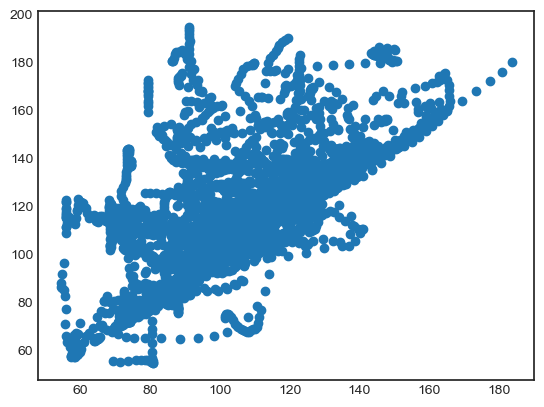

In [166]:
plt.scatter(label_all[:, list_output.index('HR_cosmed')], label_all[:, list_output.index('HR_patch')])

(array([  97.,  480.,  847., 1539., 1557.,  778.,  423.,  159.,  107.,
          60.]),
 array([ 54.51941657,  68.51391706,  82.50841755,  96.50291804,
        110.49741853, 124.49191902, 138.48641951, 152.48092   ,
        166.47542049, 180.46992098, 194.46442147]),
 <a list of 10 Patch objects>)

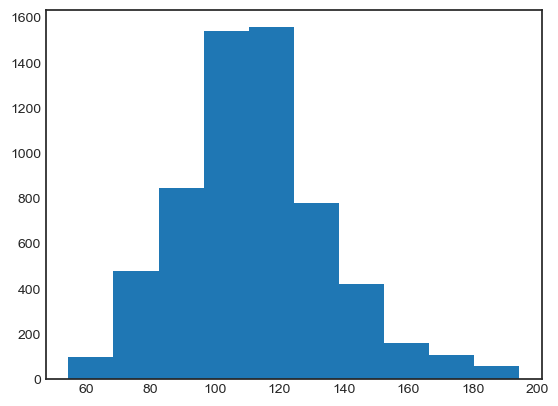

In [167]:
plt.hist(label_all[:, list_output.index('HR_patch')])

(array([ 418., 1184., 1339., 1304., 1191.,  362.,  131.,   91.,   15.,
          12.]),
 array([ 6.21276668, 11.90442002, 17.59607336, 23.2877267 , 28.97938004,
        34.67103338, 40.36268672, 46.05434006, 51.7459934 , 57.43764674,
        63.12930008]),
 <a list of 10 Patch objects>)

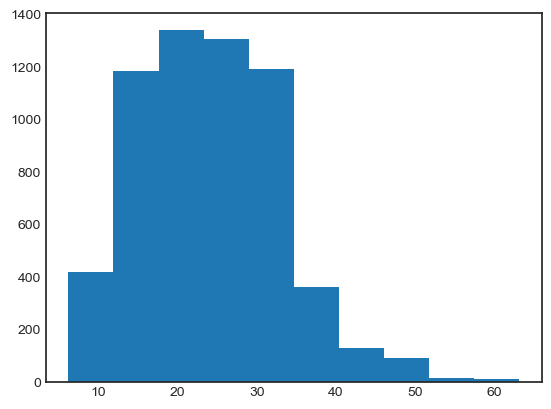

In [168]:
plt.hist(label_all[:, list_output.index('RR_cosmed')])

In [169]:
# label_all.shape

In [170]:
# meta_all[0].astype(int)

In [171]:
# len(data_all), data_all[0].shape

In [172]:
# len(feature_all), feature_all[0].shape

In [173]:
# sys.exit()

In [174]:
data_all.shape, feature_all.shape, label_all.shape, meta_all.shape

((6047, 15, 6000), (6047, 47), (6047, 15), (6047, 3))

In [175]:
len(list_signal),len(list_feature), len(list_output), len(list_meta)

(15, 47, 15, 3)

# save all data

In [176]:
stage3_dict = {
    'list_feature': list_feature,
    'list_output': list_output,
    'list_meta': list_meta,
    'list_signal': list_signal,
    'FS_RESAMPLE_DL': FS_RESAMPLE_DL,
    'subject_ids': np.unique(meta_all[:,0]),
    'task_ids': np.unique(meta_all[:,1]),
    'window_size': window_size,
    'overlap': overlap,
    'df_subinfo': df_subinfo,
    'NF_dict_subs': NF_dict_subs,
    'sequence': training_params['sequence'],
    'downsample_factor': downsample_factor,
    'FS_RESAMPLE_resp': FS_RESAMPLE_resp,
    
    'task_names_all': task_names,
    'ECG_patch_noisy': ECG_patch_noisy,
    'tasks_dict': tasks_dict,
    'tasks_dict_reversed': tasks_dict_reversed,
    'unit_dict': unit_dict,
}

data_saver(stage3_dict, 'stage3_dict', outputdir)

In [177]:
# stage3_dict.keys()

In [178]:
# data_all

In [179]:
data_saver(data_all, 'data', outputdir)
# del data_all
data_saver(feature_all, 'feature', outputdir)
# del feature_all
data_saver(label_all, 'label', outputdir)
# del label_all
data_saver(meta_all, 'meta', outputdir)
# del meta_all

In [180]:
sys.exit()

SystemExit: 

/home/mchan/miniconda3/envs/mienv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [181]:
# feature_all